# Predicting Illegal dumpsites

### This notebook will contain multiple model tests.

1. First test will be a similar one to what I have done before. This time, I will have more data (and from more continents) as uploaded [here](https://drive.google.com/drive/folders/1A1uQwncP-epVXMbGHXIebmNMx8ouQvpR). The non-dumpsite data in this dataset has been created with the Foursquare API.
2. The second test will be a more significant one. It will be based off on more carefully created random points around the dumpsites, and extra variables such as number of venues and average distance to venues within a certain radius. This dataset lives [here](https://drive.google.com/file/d/1p0tkXGqsggHvxxBNtx_FVChBvTsfprmO/view).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
"""
required libraries imported
"""

! pip install category_encoders --quiet

import category_encoders as ce

import os, io, sys, random, time, pprint, math, csv
import numpy as np
from numpy import save, load
from itertools import chain
from pylab import rcParams
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import one_hot
from tensorflow.keras.callbacks import LambdaCallback, Callback, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.models import load_model
from tensorflow.keras import Model, Sequential
from tensorflow.keras import backend, regularizers
from tensorflow.keras.layers import Activation, Reshape, Dense, Embedding, Dropout, Input, BatchNormalization, concatenate, Flatten, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adadelta, Adagrad, Adamax
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

     |████████████████████████████████| 81kB 2.5MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# ABANDONED Test 1 - not a lot of data

## First test on previously available data. We are not using this test 1 anymore because the dataset was very old with very few variables and examples.

If you want to look at test 1 code (why?), then contact Ram.

# Data Preparation

In [ ]:
#@title ## Loading Data
# training data
final = pd.read_csv('/content/drive/My Drive/Official folder for Trashout/Task_1/T1_Datasets/Final Datasets/Complete_dumpSites.csv')
print(f"final has shape {final.shape}")

final_random = pd.read_csv('/content/drive/My Drive/Official folder for Trashout/Task_1/T1_Datasets/Final Datasets/Complete_randomPoints_1km.csv')
print(f"final_random has shape {final_random.shape}")

# testing data
final_test = pd.read_csv('/content/drive/My Drive/Official folder for Trashout/Task_1/T1_Datasets/Final Datasets/Complete_dumpSites_Test.csv')
print(f"final_test has shape {final_test.shape}")

final_random_test = pd.read_csv('/content/drive/My Drive/Official folder for Trashout/Task_1/T1_Datasets/Final Datasets/Complete_randomPoints_1km_Test.csv')
print(f"final_random_test has shape {final_random_test.shape}")

final has shape (44881, 20)
final_random has shape (44545, 20)
final_test has shape (11217, 20)
final_random_test has shape (11133, 20)


In [ ]:
(list(final.columns) == list(final_random.columns) == list(final_test.columns) 
== list(final_random_test.columns))

# all columns are same, no need to rename anything

True

## Exploring the data

In [ ]:
final.head()

,TrashOutID,Lat,Lon,Continent,Distance to Road,Population Density,Population gradient,Distance to Nearest Venue,Number of Venues,Avg Dist to Venues,1stMostFreq,2ndMostFreq,3rdMostFreq,4thMostFreq,5thMostFreq,1stClosest,2ndClosest,3rdClosest,4thClosest,5thClosest
0,57837,-26.196481,28.050331,Africa,25.118444,12718.73,0.840314,332,24,706.25,Fast Food Restaurant,Portuguese Restaurant,Shopping Mall,Fried Chicken Joint,Hotel,Art Gallery,Shopping Mall,Convenience Store,Seafood Restaurant,Theater
1,57831,-28.466159,28.855491,Africa,16.073944,1704.99,0.714321,1500,0,3000.00,None,None,None,None,None,None,None,None,None,None
2,57830,-28.514575,28.820170,Africa,33.621466,3842.15,0.494658,496,4,620.00,Auto Workshop,Beer Garden,Restaurant,Gas Station,None,Restaurant,Gas Station,Auto Workshop,Beer Garden,None
3,57829,-29.947538,30.915913,Africa,32.739744,11928.59,0.327302,61,1,61.00,Shopping Mall,None,None,None,None,Shopping Mall,None,None,None,None
4,57817,-26.376726,27.300703,Africa,6.813308,2.17,0.493056,1500,0,3000.00,None,None,None,None,None,None,None,None,None,None


In [ ]:
final_random.head()

,TrashOutID,Lat,Lon,Continent,Distance to Road,Population Density,Population gradient,Distance to Nearest Venue,Number of Venues,Avg Dist to Venues,1stMostFreq,2ndMostFreq,3rdMostFreq,4thMostFreq,5thMostFreq,1stClosest,2ndClosest,3rdClosest,4thClosest,5thClosest
0,57836,-26.174340,27.985381,Africa,48.082264,4436.40,0.596904,420,5,607.600000,Restaurant,Shopping Mall,Supermarket,Tennis Court,Fast Food Restaurant,Tennis Court,Shopping Mall,Fast Food Restaurant,Supermarket,Restaurant
1,57831,-28.473954,28.859991,Africa,150.000000,2167.54,0.636909,1500,0,3000.000000,None,None,None,None,None,None,None,None,None,None
2,57830,-28.506780,28.815669,Africa,53.892441,3341.90,0.561918,634,3,757.666667,Construction & Landscaping,Gas Station,Restaurant,None,None,Restaurant,Gas Station,Construction & Landscaping,None,None
3,57828,-26.247996,27.703924,Africa,21.060757,5.65,0.499462,1500,0,3000.000000,None,None,None,None,None,None,None,None,None,None
4,57813,-26.022699,28.006938,Africa,10.986695,3039.87,0.360769,317,41,744.243902,Italian Restaurant,Hotel,Coffee Shop,Shopping Mall,Theater,Department Store,Zoo,Hotel,Comedy Club,Coffee Shop


In [ ]:
final_test.head()

,TrashOutID,Lat,Lon,Continent,Distance to Road,Population Density,Population gradient,Distance to Nearest Venue,Number of Venues,Avg Dist to Venues,1stMostFreq,2ndMostFreq,3rdMostFreq,4thMostFreq,5thMostFreq,1stClosest,2ndClosest,3rdClosest,4thClosest,5thClosest
0,57836,-26.182135,27.989881,Africa,44.673641,3553.60,0.317897,341,5,654.2,Bar,Tennis Court,Restaurant,Student Center,Bus Station,Restaurant,Bar,Student Center,Tennis Court,Bus Station
1,57828,-26.243496,27.696129,Africa,1.472705,314.45,0.923777,1500,0,3000.0,None,None,None,None,None,None,None,None,None,None
2,57809,-26.241132,27.815810,Africa,9.143493,20422.59,0.343147,411,5,557.4,Fish & Chips Shop,Japanese Restaurant,Dessert Shop,Bus Station,None,Fish & Chips Shop,Fish & Chips Shop,Bus Station,Dessert Shop,Japanese Restaurant
3,57764,-25.495246,31.179170,Africa,15.193524,1.18,0.499033,1500,0,3000.0,None,None,None,None,None,None,None,None,None,None
4,57755,-26.230469,27.846345,Africa,2.803380,8480.55,0.315502,650,5,784.0,Pub,Shopping Plaza,Café,Convenience Store,None,Pub,Café,Pub,Shopping Plaza,Convenience Store


In [ ]:
final_random_test.head()

,TrashOutID,Lat,Lon,Continent,Distance to Road,Population Density,Population gradient,Distance to Nearest Venue,Number of Venues,Avg Dist to Venues,1stMostFreq,2ndMostFreq,3rdMostFreq,4thMostFreq,5thMostFreq,1stClosest,2ndClosest,3rdClosest,4thClosest,5thClosest
0,57837,-26.191981,28.042536,Africa,9.128174,45583.50,0.662325,258,44,687.136364,Coffee Shop,Fast Food Restaurant,Hotel,Art Gallery,Café,Historic Site,Theater,Art Gallery,Train Station,Hotel
1,57829,-29.938537,30.915913,Africa,2.136312,7893.65,0.622818,1500,0,3000.000000,None,None,None,None,None,None,None,None,None,None
2,57817,-26.385727,27.300703,Africa,150.000000,2.17,0.644543,1500,0,3000.000000,None,None,None,None,None,None,None,None,None,None
3,57777,-33.582348,18.468104,Africa,150.000000,9.18,0.440028,704,1,704.000000,Construction & Landscaping,None,None,None,None,Construction & Landscaping,None,None,None,None
4,57604,-33.905952,25.598207,Africa,6.882133,301.96,0.978314,375,4,642.000000,Grocery Store,Soccer Field,Fast Food Restaurant,Pub,None,Soccer Field,Pub,Fast Food Restaurant,Grocery Store,None


## Categorical Variable Preparation

## There are two categorical variables
## 1. Continent
## 2. Nearest Venue Categories (5) and most frequent venue categories (5).

## Since the cardinality of the continent is less than 15, a one-hot encoding would be good.

## **_The Venue categories variables will be transformed as per the different tests in the following sections._**

In [ ]:
final.shape, final.isnull().sum()

((44881, 20), TrashOutID                     0
 Lat                            0
 Lon                            0
 Continent                     40
 Distance to Road               0
 Population Density           120
 Population gradient          120
 Distance to Nearest Venue      0
 Number of Venues               0
 Avg Dist to Venues             0
 1stMostFreq                    0
 2ndMostFreq                    0
 3rdMostFreq                    0
 4thMostFreq                    0
 5thMostFreq                    0
 1stClosest                     0
 2ndClosest                     0
 3rdClosest                     0
 4thClosest                     0
 5thClosest                     0
 dtype: int64)

In [ ]:
final_random.shape, final_random.isnull().sum()

((44545, 20), TrashOutID                     0
 Lat                            0
 Lon                            0
 Continent                     40
 Distance to Road               0
 Population Density           314
 Population gradient          314
 Distance to Nearest Venue      0
 Number of Venues               0
 Avg Dist to Venues             0
 1stMostFreq                    0
 2ndMostFreq                    0
 3rdMostFreq                    0
 4thMostFreq                    0
 5thMostFreq                    0
 1stClosest                     0
 2ndClosest                     0
 3rdClosest                     0
 4thClosest                     0
 5thClosest                     0
 dtype: int64)

In [ ]:
set(final['Continent']), set(final_random['Continent'])

({'Africa',
  'Asia',
  'Australia',
  'Europe',
  'North America',
  'Oceania',
  'South America',
  nan},
 {'Africa',
  'Asia',
  'Australia',
  'Europe',
  'North America',
  'Oceania',
  'South America',
  nan})

In [ ]:
#@markdown ## Removing NaN values
"""
removing null values from Continent variables
"""

final = final[final['Continent'].notna()]
final_random = final_random[final_random['Continent'].notna()]

final_test = final_test[final_test['Continent'].notna()]
final_random_test = final_random_test[final_random_test['Continent'].notna()]

In [ ]:
final['Continent'].isnull().any(), final_random['Continent'].isnull().any(), final_test['Continent'].isnull().any(), final_random_test['Continent'].isnull().any()

# great, null values removed from Continent of both training and test sets

(False, False, False, False)

In [ ]:
set(final['Continent']), set(final_random['Continent']), set(final_test['Continent']), set(final_random_test['Continent'])

({'Africa',
  'Asia',
  'Australia',
  'Europe',
  'North America',
  'Oceania',
  'South America'},
 {'Africa',
  'Asia',
  'Australia',
  'Europe',
  'North America',
  'Oceania',
  'South America'},
 {'Africa',
  'Asia',
  'Australia',
  'Europe',
  'North America',
  'Oceania',
  'South America'},
 {'Africa',
  'Asia',
  'Australia',
  'Europe',
  'North America',
  'Oceania',
  'South America'})

In [ ]:
print("Oceania examples in training set: ", len(final[final['Continent'] == 'Oceania']), len(final_random[final_random['Continent'] == 'Oceania']))
print("Oceania examples in test set: ", len(final_test[final_test['Continent'] == 'Oceania']), len(final_random_test[final_random_test['Continent'] == 'Oceania']))

Oceania examples in training set:  9 9
Oceania examples in test set:  2 2


In [ ]:
#@markdown ## Converting continent to one-hot encoding
"""
making the continent into one-hot encoding for both datasets
"""

train_dumpsite_dummies = pd.get_dummies(final['Continent'])
final = pd.concat([final.drop('Continent', axis=1), train_dumpsite_dummies], axis=1)

train_nondumpsite_dummies = pd.get_dummies(final_random['Continent'])
final_random = pd.concat([final_random.drop('Continent', axis=1), train_nondumpsite_dummies], axis=1)

test_dumpsite_dummies = pd.get_dummies(final_test['Continent'])
final_test = pd.concat([final_test.drop('Continent', axis=1), test_dumpsite_dummies], axis=1)

test_nondumpsite_dummies = pd.get_dummies(final_random_test['Continent'])
final_random_test = pd.concat([final_random_test.drop('Continent', axis=1), test_nondumpsite_dummies], axis=1)

In [ ]:
#@markdown ## Adding target labels
"""
adding target labels
"""

if 'target' not in final.columns + final_random.columns:
    final['target'] = 1
    final_random['target'] = 0

if 'target' not in final_test.columns + final_random_test.columns:
    final_test['target'] = 1
    final_random_test['target'] = 0

# Test 2 - using venue encodings

This second test will be a more significant one. It will be based off on more carefully created random points around the dumpsites, and extra variables such as number of venues, average distance to venues, 5 nearest venue categories, 5 most frequent venue categories, distance to nearest venue, and a categorial label for distance to roads. The dataset for the extra variables lives [here](https://drive.google.com/drive/folders/1FefJE1GaNCUivJdc6gpgcjibmVzTGQ7d).

## Test 2.0 - Leave One Out Encoding on venue categories (all 10 variables).

In [ ]:
# combined data of dumpsites and non-dumpsites in train and test sets

data = pd.concat([final, final_random], axis=0)

data_test = pd.concat([final_test, final_random_test], axis=0)

In [ ]:
"""
Applying an encoding onto the 10 different columns (#thMostFreq and #thClosest) categorical variables
"""

columns = ['1stMostFreq', '2ndMostFreq', '3rdMostFreq', '4thMostFreq', '5thMostFreq', '1stClosest', '2ndClosest', '3rdClosest', '4thClosest', '5thClosest']

for col in columns: 
  # training
  leaveoneoutenc = ce.LeaveOneOutEncoder(return_df=True)
  leaveoneoutenc.fit(X=data[col], y=data['target'])

  data[col + 'leaveoneout_enc'] = leaveoneoutenc.transform(data[col])
  data.drop([col], axis=1, inplace=True)
  
  #testing
  data_test[col + 'leaveoneout_enc'] = leaveoneoutenc.transform(data_test[col])
  data_test.drop([col], axis=1, inplace=True)
  data_test.head()

data.drop(['Lat', 'Lon', 'TrashOutID'], axis=1, inplace=True)
data_test.drop(['Lat', 'Lon', 'TrashOutID'], axis=1, inplace=True)

data.head()

In [ ]:
"""
removing any null values in other variables
"""

print(data.shape, data_test.shape)

data.dropna(inplace=True)
data_test.dropna(inplace=True)

data.shape, data_test.shape

((88916, 24), (22222, 24))

### Building a Model (leave one out encoding)

In [ ]:
"""
training and testing separation
"""

X = data.drop(['target'], axis=1).to_numpy()
Y = data['target'].to_numpy()

test_x = data_test.drop(['target'], axis=1).to_numpy()
test_y = data_test['target'].to_numpy()

using_kfold = True

if not using_kfold:
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,
                                                    stratify=Y,
                                                    random_state=111)
  print(f"X_train is {X_train.shape}", f"X_test is {X_test.shape}")

else:
  X_train = X
  Y_train = Y
  print(f"X_train is {X_train.shape}", f"Y_train is {Y_train.shape}")

X_train is (88916, 23) Y_train is (88916,)


In [ ]:
"""
normalizing the continuous variables
"""

scaler = StandardScaler()

scaler.fit(X_train[:, :6])

X_train[:, :6] = scaler.transform(X_train[:, :6])

if not using_kfold:
  X_test[:, :6] = scaler.transform(X_test[:, :6]) 
  print(f"X_train is {X_train.shape}", f"X_test is {X_test.shape}")
else:
  X_train.shape

(88916, 23)

In [ ]:
"""
building the model
"""

x_input = Input(shape=(X_train.shape[-1],), name='input_layer')

x = Dense(units=32, activation='relu', name=f'dense_1',
          kernel_regularizer=regularizers.l2(1e-4),
          bias_regularizer=regularizers.l2(1e-4),
          activity_regularizer=regularizers.l2(1e-4))(x_input)

# x = Dropout(rate=0.2, name=f'dropout_1')(x)

for i, unit in enumerate([32, 32], start=2):
    x = Dense(units=unit, activation='relu', name=f'dense_{i}',
              kernel_regularizer=regularizers.l2(1e-4),
              bias_regularizer=regularizers.l2(1e-4),
              activity_regularizer=regularizers.l2(1e-4))(x)
    
    # x = BatchNormalization(name=f'batchnorm_{i}')(x)
    # x = Dropout(rate=0.2, name=f'dropout_{i}')(x)

out = Dense(units=1, activation='sigmoid', name='output_layer')(x)

model = Model(inputs=x_input, outputs=out, name='Dumpsite_Prediction_Model')

# saving the model graph and seeing the architecture 
plot_model(model, show_shapes=True, to_file='/content/drive/My Drive/Official folder for Trashout/Task_1/models/final_model/leaveoneoutencoding/nn_graph.png')

model.summary()

Model: "Dumpsite_Prediction_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 23)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                768       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
output_layer (Dense)         (None, 1)                 33        
Total params: 2,913
Trainable params: 2,913
Non-trainable params: 0
_________________________________________________________________


### Using K-Fold for better learning

In [ ]:
"""
using the sklearn library to split the training data
into folds of training and validation splits
"""

n_split=10

fold = StratifiedShuffleSplit(n_splits=n_split, test_size=0.15,
                               random_state=111)

train_acc=[]
train_loss=[]
val_acc=[]
val_loss=[]
hists = []

fold.get_n_splits(X_train, Y_train)

10

### Training for LeaveOneOut encoding

In [ ]:
"""
compiling and fitting
"""

filepath_curr = '/content/drive/My Drive/Official folder for Trashout/Task_1/models/final_model/leaveoneoutencoding/curr_model.h5'

checkpoint = ModelCheckpoint(filepath=filepath_curr, monitor='val_accuracy', save_best_only=True)

opts = Adam(learning_rate=0.001, epsilon=1e-8, decay=0.0001)

# model will begin training with previously trained weights
try:
    model.load_weights(filepath_curr)
    print('Same architecture as before.\n\n')
except:
    print('Model architecture has been changed. No weights loaded.\n\n')

i = 1 # counter for print statement

if not using_kfold:
  model.compile(optimizer=opts, loss='binary_crossentropy', metrics=['accuracy'])
  history = model.fit(
      X_train,
      Y_train,
      batch_size=128,
      epochs=75,
      validation_data=(X_test, Y_test),
      callbacks=[checkpoint],
      verbose=2
  )
else:
  for train_index, val_index in fold.split(X_train, Y_train):

      train_x, val_x = X_train[train_index], X_train[val_index]
      train_y, val_y = Y_train[train_index], Y_train[val_index]

      model.compile(optimizer=opts, loss='binary_crossentropy', metrics=['accuracy'])
          
      history = model.fit(
          train_x,
          train_y,
          batch_size=128,
          epochs=75,
          validation_data=(val_x, val_y),
          callbacks=[checkpoint],
          verbose=0
      )

      curr_train_acc = round(model.evaluate(train_x, train_y, verbose=0)[1]*100, 2)
      curr_val_acc = round(model.evaluate(val_x, val_y, verbose=0)[1]*100, 2)

      curr_train_loss = model.evaluate(train_x, train_y, verbose=0)[0]
      curr_val_loss = model.evaluate(val_x, val_y, verbose=0)[0]

      print("-"*75)
      print(f"Fold {i}: train acc = {curr_train_acc}%")
      print(f"Fold {i}: val acc = {curr_val_acc}%")
      print("-"*75 + "\n\n")

      train_acc.append(curr_train_acc)
      val_acc.append(curr_val_acc)
      train_loss.append(curr_train_loss)
      val_loss.append(curr_val_loss)

      i += 1

Same architecture as before.


---------------------------------------------------------------------------
Fold 1: train acc = 76.83%
Fold 1: val acc = 76.6%
---------------------------------------------------------------------------


---------------------------------------------------------------------------
Fold 2: train acc = 76.99%
Fold 2: val acc = 75.99%
---------------------------------------------------------------------------


---------------------------------------------------------------------------
Fold 3: train acc = 76.83%
Fold 3: val acc = 76.89%
---------------------------------------------------------------------------


---------------------------------------------------------------------------
Fold 4: train acc = 76.86%
Fold 4: val acc = 76.95%
---------------------------------------------------------------------------


---------------------------------------------------------------------------
Fold 5: train acc = 76.96%
Fold 5: val acc = 76.82%
------------------

### Evaluating average accuracy and loss after K-Fold

In [ ]:
if using_kfold:
  for i, v in enumerate(train_acc, start=0):
    print('-'*50)
    print(f'Fold {i+1} - Train Loss: {train_loss[i]} - Train Accuracy: {train_acc[i]}%')
    print(f'Fold {i+1} - Validation Loss: {val_loss[i]} - Validation Accuracy: {val_acc[i]}%')

  print('-'*50)

  print('\n\nAverage scores for all folds:\n\n')
  # training
  print(f'Train Accuracy: {round(np.mean(train_acc), 2)} +- {round(np.std(train_acc), 2)}')
  print(f'Train Loss: {round(np.mean(train_loss), 3)}')
  # validation
  print(f'\n\nTest Accuracy: {round(np.mean(val_acc), 2)} +- {round(np.std(val_acc), 2)}')
  print(f'Test Loss: {round(np.mean(val_loss), 3)}')

--------------------------------------------------
Fold 1 - Train Loss: 0.48650896549224854 - Train Accuracy: 76.61%
Fold 1 - Validation Loss: 0.4931194484233856 - Validation Accuracy: 76.32%
--------------------------------------------------
Fold 2 - Train Loss: 0.4854697287082672 - Train Accuracy: 76.69%
Fold 2 - Validation Loss: 0.49903029203414917 - Validation Accuracy: 76.03%
--------------------------------------------------
Fold 3 - Train Loss: 0.4847656786441803 - Train Accuracy: 76.73%
Fold 3 - Validation Loss: 0.48658284544944763 - Validation Accuracy: 76.75%
--------------------------------------------------
Fold 4 - Train Loss: 0.48518624901771545 - Train Accuracy: 76.76%
Fold 4 - Validation Loss: 0.4859186112880707 - Validation Accuracy: 76.7%
--------------------------------------------------
Fold 5 - Train Loss: 0.4839475154876709 - Train Accuracy: 76.79%
Fold 5 - Validation Loss: 0.4874090552330017 - Validation Accuracy: 76.77%
------------------------------------------

In [ ]:
"""
this code takes care of saving the new model only if its accuracy is better than
that of the last model
"""

filepath = '/content/drive/My Drive/Official folder for Trashout/Task_1/models/final_model/leaveoneoutencoding/best_model.h5'
filepath_curr = '/content/drive/My Drive/Official folder for Trashout/Task_1/models/final_model/leaveoneoutencoding/curr_model.h5'


if os.path.exists(filepath):
  prev_model = load_model(filepath)
  curr_model = load_model(filepath_curr)

  prev_acc = prev_model.evaluate(test_x, test_y, verbose=0)[1]
  curr_acc = curr_model.evaluate(test_x, test_y, verbose=0)[1]

  if curr_acc > prev_acc:
    print("There was a previous model saved.\n")
    print(f"Previous test accuracy: {round(prev_acc*100, 2)}%")
    print(f"Current test accuracy: {round(curr_acc*100, 2)}%")
    curr_model.save(filepath)
    print('\nNew model is saved.')
  else:
    print(f"Previous test accuracy: {round(prev_acc*100, 2)}%")
    print(f"Current test accuracy: {round(curr_acc*100, 2)}%")
    print('Old model is kept.')

else: # if this is the first time saving the model
  model.save(filepath)
  curr_model = load_model(filepath)
  curr_acc = curr_model.evaluate(test_x, test_y, verbose=0)[1]
  print(f"Current test accuracy: {round(curr_acc*100, 2)}%")
  print('\nFirst time model is saved.')

Previous test accuracy: 50.32%
Current test accuracy: 50.31%
Old model is kept.


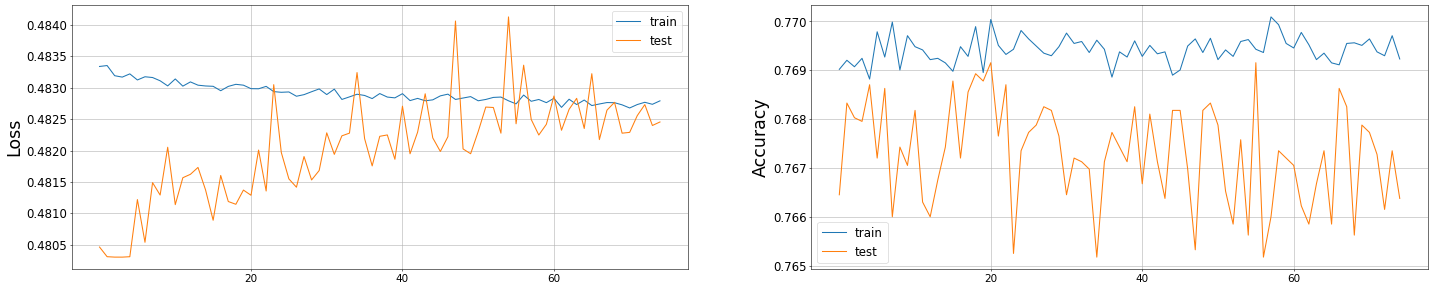

In [ ]:
"""
looking at the train/test loss and accuracy over the epochs
"""

width_in_inches = 35
height_in_inches = 7
dots_per_inch = 50

plt.figure(
    figsize=(width_in_inches, height_in_inches), dpi=dots_per_inch)

# PICK THE FOLD
fold = 5

# plot loss during training
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylabel('Loss', fontsize=25, color='black')
plt.xticks(range(20, len(history.history['loss'])+1, 20), fontsize=15, color='black')
plt.yticks(fontsize=17, color='black')
plt.legend(loc='upper right', fontsize=17)
plt.grid()
plt.savefig('/content/drive/My Drive/Official folder for Trashout/Task_1/models/final_model/leaveoneoutencoding/train.png')

# plot accuracy during training
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.ylabel('Accuracy', fontsize=25, color='black')
plt.xticks(range(20, len(history.history['accuracy'])+1, 20), fontsize=15, color='black')
plt.yticks(fontsize=17, color='black')
plt.legend(fontsize=17)
plt.grid()
plt.savefig('/content/drive/My Drive/Official folder for Trashout/Task_1/models/final_model/leaveoneoutencoding/test.png')

plt.show()

In [ ]:
"""
printing the confusion matrix
"""

preds = load_model(filepath).predict(test_x).squeeze()

assert preds.shape == test_y.shape, 'The shapes of the two tensors are unequal'

print(confusion_matrix(test_y, np.round(preds)))

print(classification_report(test_y, np.round(preds)))

[[    0 11040]
 [    0 11182]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     11040
           1       0.50      1.00      0.67     11182

    accuracy                           0.50     22222
   macro avg       0.25      0.50      0.33     22222
weighted avg       0.25      0.50      0.34     22222



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Test 2.1 - Frequency Encoding on venue categories (all 10 variables).

In [ ]:
# combined data of dumpsites and non-dumpsites in train and test sets

datad = pd.concat([final, final_random], axis=0)

datad_test = pd.concat([final_test, final_random_test], axis=0)

In [ ]:
datad.shape, datad_test.shape

((89346, 27), (22330, 27))

In [ ]:
"""
Applying an encoding onto the 10 different columns (#thMostFreq and #thClosest) categorical variables
"""

columns = ['1stMostFreq', '2ndMostFreq', '3rdMostFreq', '4thMostFreq', '5thMostFreq', '1stClosest', '2ndClosest', '3rdClosest', '4thClosest', '5thClosest']

for col in columns: 
  freq = datad.groupby(col).size() / len(datad)
  
  # training
  datad[col + 'frequency_enc'] = datad[col].map(freq)
  datad.drop([col], axis=1, inplace=True)
  
  #testing
  datad_test[col + 'frequency_enc'] = datad_test[col].map(freq)
  datad_test.drop([col], axis=1, inplace=True)

datad.drop(['TrashOutID', 'Lat', 'Lon'], axis=1, inplace=True)
datad_test.drop(['TrashOutID', 'Lat', 'Lon'], axis=1, inplace=True)

# try frequency encoding as in this article
# https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02


datad.head()

,Distance to Road,Population Density,Population gradient,Distance to Nearest Venue,Number of Venues,Avg Dist to Venues,Africa,Asia,Australia,Europe,North America,Oceania,South America,target,1stMostFreqfrequency_enc,2ndMostFreqfrequency_enc,3rdMostFreqfrequency_enc,4thMostFreqfrequency_enc,5thMostFreqfrequency_enc,1stClosestfrequency_enc,2ndClosestfrequency_enc,3rdClosestfrequency_enc,4thClosestfrequency_enc,5thClosestfrequency_enc
0,25.118444,12718.73,0.840314,332,24,706.25,1,0,0,0,0,0,0,1,0.008764,0.001086,0.008103,0.001063,0.013632,0.000851,0.006324,0.007029,0.006469,0.000638
1,16.073944,1704.99,0.714321,1500,0,3000.00,1,0,0,0,0,0,0,1,0.300618,0.420534,0.505540,0.584301,0.679840,0.300618,0.412665,0.488237,0.544591,0.642983
2,33.621466,3842.15,0.494658,496,4,620.00,1,0,0,0,0,0,0,1,0.001578,0.001757,0.029190,0.001589,0.679840,0.034383,0.002462,0.001198,0.001601,0.642983
3,32.739744,11928.59,0.327302,61,1,61.00,1,0,0,0,0,0,0,1,0.004432,0.420534,0.505540,0.584301,0.679840,0.004969,0.412665,0.488237,0.544591,0.642983
4,6.813308,2.17,0.493056,1500,0,3000.00,1,0,0,0,0,0,0,1,0.300618,0.420534,0.505540,0.584301,0.679840,0.300618,0.412665,0.488237,0.544591,0.642983


In [ ]:
"""
removing any null values in other variables
"""

print(datad.shape, datad_test.shape)

datad.dropna(inplace=True)
datad_test.dropna(inplace=True)

datad.shape, datad_test.shape

(89346, 24) (22330, 24)


((88916, 24), (22091, 24))

### Building a Model (frequency encoding)

In [ ]:
"""
training and testing separation
"""

X = datad.drop(['target'], axis=1).to_numpy()
Y = datad['target'].to_numpy()

test_x = datad_test.drop(['target'], axis=1).to_numpy()
test_y = datad_test['target'].to_numpy()

using_kfold = True

if not using_kfold:
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,
                                                    stratify=Y,
                                                    random_state=111)
  print(f"X_train is {X_train.shape}", f"X_test is {X_test.shape}")

else:
  X_train = X
  Y_train = Y
  print(f"X_train is {X_train.shape}", f"Y_train is {Y_train.shape}")

X_train is (88916, 23) Y_train is (88916,)


In [ ]:
"""
normalizing the continuous variables
"""

scaler = StandardScaler()

scaler.fit(X_train[:, :6])

X_train[:, :6] = scaler.transform(X_train[:, :6])

if not using_kfold:
  X_test[:, :6] = scaler.transform(X_test[:, :6]) 
  print(f"X_train is {X_train.shape}", f"X_test is {X_test.shape}")
else:
  X_train.shape

(88916, 23)

In [ ]:
"""
building the model
"""

x_input = Input(shape=(X_train.shape[-1],), name='input_layer')

x = Dense(units=32, activation='relu', name=f'dense_1',
          kernel_regularizer=regularizers.l2(1e-4))(x_input)

# x = Dropout(rate=0.2, name=f'dropout_1')(x)

for i, unit in enumerate([32, 32], start=2):
    x = Dense(units=unit, activation='relu', name=f'dense_{i}',
              kernel_regularizer=regularizers.l2(1e-4))(x)
    # x = Dropout(rate=0.2, name=f'dropout_{i}')(x)
    # x = BatchNormalization(name=f'batchnorm_{i}')(x)

out = Dense(units=1, activation='sigmoid', name='output_layer')(x)

model = Model(inputs=x_input, outputs=out, name='Dumpsite_Prediction_Model')

# saving the model graph and seeing the architecture 
plot_model(model, show_shapes=True, to_file='/content/drive/My Drive/Official folder for Trashout/Task_1/models/final_model/frequencyencoding/nn_graph.png')

model.summary()

Model: "Dumpsite_Prediction_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 23)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                768       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
output_layer (Dense)         (None, 1)                 33        
Total params: 2,913
Trainable params: 2,913
Non-trainable params: 0
_________________________________________________________________


### Using K-Fold for better learning

In [ ]:
"""
using the sklearn library to split the training data
into folds of training and validation splits
"""

n_split=10

fold = StratifiedShuffleSplit(n_splits=n_split, test_size=0.15,
                              random_state=111)

train_acc=[]
train_loss=[]
val_acc=[]
val_loss=[]
hists = []

fold.get_n_splits(X_train, Y_train)

10

### Training for Frequency encoding

In [ ]:
"""
compiling and fitting
"""

filepath_curr = '/content/drive/My Drive/Official folder for Trashout/Task_1/models/final_model/frequencyencoding/curr_model.h5'

checkpoint = ModelCheckpoint(filepath=filepath_curr, monitor='val_accuracy', save_best_only=True)

opts = Adam(learning_rate=0.001, epsilon=1e-8, decay=0.0001)

# model will begin training with previously trained weights
try:
    model.load_weights(filepath_curr)
    print('Same architecture as before.\n\n')
except:
    print('Model architecture has been changed. No weights loaded.\n\n')

i = 1 # counter for print statement

if not using_kfold:
  model.compile(optimizer=opts, loss='binary_crossentropy', metrics=['accuracy'])
  history = model.fit(
      X_train,
      Y_train,
      batch_size=128,
      epochs=75,
      validation_data=(X_test, Y_test),
      callbacks=[checkpoint],
      verbose=2
  )
else:
  for train_index, val_index in fold.split(X_train, Y_train):

      train_x, val_x = X_train[train_index], X_train[val_index]
      train_y, val_y = Y_train[train_index], Y_train[val_index]

      model.compile(optimizer=opts, loss='binary_crossentropy', metrics=['accuracy'])
          
      history = model.fit(
          train_x,
          train_y,
          batch_size=128,
          epochs=75,
          validation_data=(val_x, val_y),
          callbacks=[checkpoint],
          verbose=0
      )

      curr_train_acc = round(model.evaluate(train_x, train_y, verbose=0)[1]*100, 2)
      curr_val_acc = round(model.evaluate(val_x, val_y, verbose=0)[1]*100, 2)

      curr_train_loss = model.evaluate(train_x, train_y, verbose=0)[0]
      curr_val_loss = model.evaluate(val_x, val_y, verbose=0)[0]

      print("-"*75)
      print(f"Fold {i}: train acc = {curr_train_acc}%")
      print(f"Fold {i}: val acc = {curr_val_acc}%")
      print("-"*75 + "\n\n")

      train_acc.append(curr_train_acc)
      val_acc.append(curr_val_acc)
      train_loss.append(curr_train_loss)
      val_loss.append(curr_val_loss)

      i += 1

Same architecture as before.


---------------------------------------------------------------------------
Fold 1: train acc = 71.33%
Fold 1: val acc = 70.66%
---------------------------------------------------------------------------


---------------------------------------------------------------------------
Fold 2: train acc = 71.46%
Fold 2: val acc = 70.03%
---------------------------------------------------------------------------


---------------------------------------------------------------------------
Fold 3: train acc = 71.56%
Fold 3: val acc = 70.75%
---------------------------------------------------------------------------


---------------------------------------------------------------------------
Fold 4: train acc = 71.53%
Fold 4: val acc = 71.48%
---------------------------------------------------------------------------


---------------------------------------------------------------------------
Fold 5: train acc = 71.56%
Fold 5: val acc = 71.19%
-----------------

### Evaluating average accuracy and loss after K-Fold

In [ ]:
if using_kfold:
  for i, v in enumerate(train_acc, start=0):
    print('-'*50)
    print(f'Fold {i+1} - Train Loss: {train_loss[i]} - Train Accuracy: {train_acc[i]}%')
    print(f'Fold {i+1} - Validation Loss: {val_loss[i]} - Validation Accuracy: {val_acc[i]}%')

  print('-'*50)

  print('\n\nAverage scores for all folds:\n\n')
  # training
  print(f'Train Accuracy: {round(np.mean(train_acc), 2)} +- {round(np.std(train_acc), 2)}')
  print(f'Train Loss: {round(np.mean(train_loss), 3)}')
  # validation
  print(f'\n\nTest Accuracy: {round(np.mean(val_acc), 2)} +- {round(np.std(val_acc), 2)}')
  print(f'Test Loss: {round(np.mean(val_loss), 3)}')

--------------------------------------------------
Fold 1 - Train Loss: 0.5680950880050659 - Train Accuracy: 71.33%
Fold 1 - Validation Loss: 0.5826188325881958 - Validation Accuracy: 70.66%
--------------------------------------------------
Fold 2 - Train Loss: 0.5660271048545837 - Train Accuracy: 71.46%
Fold 2 - Validation Loss: 0.5841373205184937 - Validation Accuracy: 70.03%
--------------------------------------------------
Fold 3 - Train Loss: 0.5650194883346558 - Train Accuracy: 71.56%
Fold 3 - Validation Loss: 0.5743318200111389 - Validation Accuracy: 70.75%
--------------------------------------------------
Fold 4 - Train Loss: 0.5657946467399597 - Train Accuracy: 71.53%
Fold 4 - Validation Loss: 0.5652322769165039 - Validation Accuracy: 71.48%
--------------------------------------------------
Fold 5 - Train Loss: 0.5649651885032654 - Train Accuracy: 71.56%
Fold 5 - Validation Loss: 0.5673887729644775 - Validation Accuracy: 71.19%
---------------------------------------------

In [ ]:
"""
this code takes care of saving the new model only if its accuracy is better than
that of the last model
"""

filepath = '/content/drive/My Drive/Official folder for Trashout/Task_1/models/final_model/frequencyencoding/best_model.h5'
filepath_curr = '/content/drive/My Drive/Official folder for Trashout/Task_1/models/final_model/frequencyencoding/curr_model.h5'


if os.path.exists(filepath):
  prev_model = load_model(filepath)
  curr_model = load_model(filepath_curr)

  prev_acc = prev_model.evaluate(test_x, test_y, verbose=0)[1]
  curr_acc = curr_model.evaluate(test_x, test_y, verbose=0)[1]

  if curr_acc > prev_acc:
    print("There was a previous model saved.\n")
    print(f"Previous test accuracy: {round(prev_acc*100, 2)}%")
    print(f"Current test accuracy: {round(curr_acc*100, 2)}%")
    curr_model.save(filepath)
    print('\nNew model is saved.')
  else:
    print(f"Previous test accuracy: {round(prev_acc*100, 2)}%")
    print(f"Current test accuracy: {round(curr_acc*100, 2)}%")
    print('Old model is kept.')

else: # if this is the first time saving the model
  model.save(filepath)
  curr_model = load_model(filepath)
  curr_acc = curr_model.evaluate(test_x, test_y, verbose=0)[1]
  print(f"Current test accuracy: {round(curr_acc*100, 2)}%")
  print('\nFirst time model is saved.')

Previous test accuracy: 52.32%
Current test accuracy: 51.08%
Old model is kept.


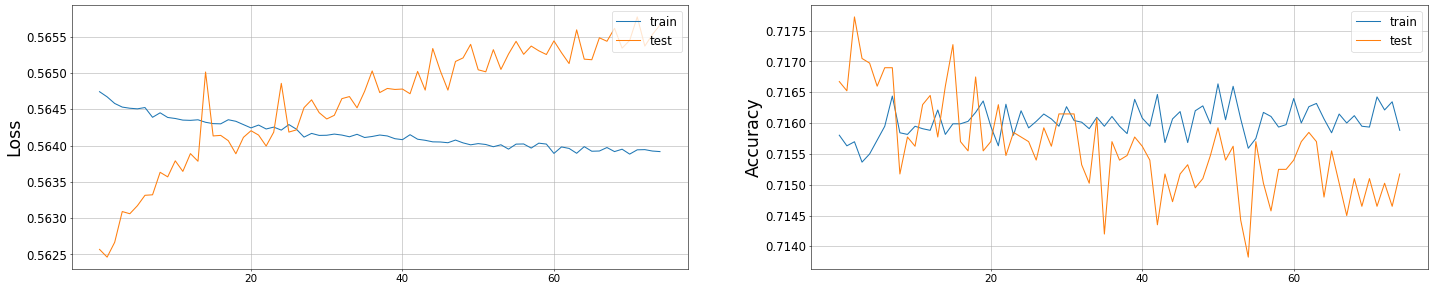

In [ ]:
"""
looking at the train/test loss and accuracy over the epochs
"""

width_in_inches = 35
height_in_inches = 7
dots_per_inch = 50

plt.figure(
    figsize=(width_in_inches, height_in_inches), dpi=dots_per_inch)

# PICK THE FOLD
fold = 5

# plot loss during training
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylabel('Loss', fontsize=25, color='black')
plt.xticks(range(20, len(history.history['loss'])+1, 20), fontsize=15, color='black')
plt.yticks(fontsize=17, color='black')
plt.legend(loc='upper right', fontsize=17)
plt.grid()
plt.savefig('/content/drive/My Drive/Official folder for Trashout/Task_1/models/final_model/frequencyencoding/train.png')

# plot accuracy during training
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.ylabel('Accuracy', fontsize=25, color='black')
plt.xticks(range(20, len(history.history['accuracy'])+1, 20), fontsize=15, color='black')
plt.yticks(fontsize=17, color='black')
plt.legend(fontsize=17)
plt.grid()
plt.savefig('/content/drive/My Drive/Official folder for Trashout/Task_1/models/final_model/frequencyencoding/test.png')

plt.show()

In [ ]:
"""
printing the confusion matrix
"""

preds = load_model(filepath).predict(test_x).squeeze()

assert preds.shape == test_y.shape, 'The shapes of the two tensors are unequal'

print(confusion_matrix(test_y, np.round(preds)))

print(classification_report(test_y, np.round(preds)))

[[7174 3799]
 [6733 4385]]
              precision    recall  f1-score   support

           0       0.52      0.65      0.58     10973
           1       0.54      0.39      0.45     11118

    accuracy                           0.52     22091
   macro avg       0.53      0.52      0.52     22091
weighted avg       0.53      0.52      0.52     22091



## Test 2.2 - Mean Encoding on venue categories (all 10 variables).

In [ ]:
datam = pd.concat([final, final_random], axis=0)

datam_test = pd.concat([final_test, final_random_test], axis=0)

In [ ]:
# Helper Class for Testing out different encodings


class MultiColumnEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit_transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        given encoder. If no columns specified, transforms all
        columns in X.
        '''
        mean = X['target'].mean()
        if self.columns is not None:
            for col in self.columns:
                agg= X.groupby(col)['target'].agg(['count','mean'])
                counts=agg['count']
                means=agg['mean']
                weight=100
                smooth = (counts*means +weight *mean) / (counts + weight)
                X.loc[:,col+'_encoding'] = X[col].map(smooth)
        else:
            for col in X.columns:
                agg= X.groupby(col)['target'].agg(['count','mean'])
                counts=agg['count']
                means=agg['mean']
                weight=100
                smooth = (counts*means +weight *mean) / (counts + weight)
                X.loc[:,col+'_encoding'] = X[col].map(smooth)
        X.drop(self.columns,axis=1,inplace=True)
        return X

columns =['1stMostFreq','2ndMostFreq','3rdMostFreq','4thMostFreq','5thMostFreq','1stClosest','2ndClosest','3rdClosest',
          '4thClosest','5thClosest']
mc_class =MultiColumnEncoder(columns)

In [ ]:

#Applying mean encoding to venue category categorical variables


datam = mc_class.fit_transform(datam)
datam.drop(['Lat', 'Lon', 'TrashOutID'], axis=1, inplace=True)

datam_test = mc_class.fit_transform(datam_test)
datam_test.drop(['Lat', 'Lon', 'TrashOutID'], axis=1, inplace=True)

datam.dropna(inplace=True)
datam_test.dropna(inplace=True)

datam.head()

,Distance to Road,Population Density,Population gradient,Distance to Nearest Venue,Number of Venues,Avg Dist to Venues,Africa,Asia,Australia,Europe,North America,Oceania,South America,target,1stMostFreq_encoding,2ndMostFreq_encoding,3rdMostFreq_encoding,4thMostFreq_encoding,5thMostFreq_encoding,1stClosest_encoding,2ndClosest_encoding,3rdClosest_encoding,4thClosest_encoding,5thClosest_encoding
0,25.118444,12718.73,0.840314,332,24,706.25,1,0,0,0,0,0,0,1,0.600439,0.594863,0.508723,0.549682,0.536561,0.529477,0.532614,0.472786,0.554850,0.504382
1,16.073944,1704.99,0.714321,1500,0,3000.00,1,0,0,0,0,0,0,1,0.454809,0.465803,0.472722,0.478925,0.485515,0.454809,0.465382,0.471071,0.475402,0.482262
2,33.621466,3842.15,0.494658,496,4,620.00,1,0,0,0,0,0,0,1,0.482108,0.592171,0.515948,0.616479,0.485515,0.536945,0.472463,0.522648,0.506947,0.482262
3,32.739744,11928.59,0.327302,61,1,61.00,1,0,0,0,0,0,0,1,0.548766,0.465803,0.472722,0.478925,0.485515,0.531596,0.465382,0.471071,0.475402,0.482262
4,6.813308,2.17,0.493056,1500,0,3000.00,1,0,0,0,0,0,0,1,0.454809,0.465803,0.472722,0.478925,0.485515,0.454809,0.465382,0.471071,0.475402,0.482262


### Building a Model(mean Encoding)


In [ ]:
"""
training and testing separation
"""

X = datam.drop(['target'], axis=1).to_numpy()
Y = datam['target'].to_numpy()

test_x = datam_test.drop(['target'], axis=1).to_numpy()
test_y = datam_test['target'].to_numpy()

using_kfold = True

if not using_kfold:
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,
                                                    stratify=Y,
                                                    random_state=111)
  print(f"X_train is {X_train.shape}", f"X_test is {X_test.shape}")

else:
  X_train = X
  Y_train = Y
  print(f"X_train is {X_train.shape}", f"Y_train is {Y_train.shape}")

X_train is (88916, 23) Y_train is (88916,)


In [ ]:
"""
normalizing the continuous variables
"""

scaler = StandardScaler()

scaler.fit(X_train[:, :6])

X_train[:, :6] = scaler.transform(X_train[:, :6])

if not using_kfold:
  X_test[:, :6] = scaler.transform(X_test[:, :6]) 
  print(f"X_train is {X_train.shape}", f"X_test is {X_test.shape}")
else:
  X_train.shape

(88916, 23)

In [ ]:
"""
building the model
"""

x_input = Input(shape=(X_train.shape[-1],), name='input_layer')

x = Dense(units=32, activation='relu', name=f'dense_1',
          bias_regularizer=regularizers.l2(1e-2),
          activity_regularizer=regularizers.l2(1e-3))(x_input)

# x = Dropout(rate=0.5, name=f'dropout_1')(x)

for i, unit in enumerate([32, 32], start=2):
    # x = Dropout(rate=0.5, name=f'dropout_{i}')(x)
    # x = BatchNormalization(name=f'batchnorm_{i}')(x)
    x = Dense(units=unit, activation='relu', name=f'dense_{i}',
              bias_regularizer=regularizers.l2(1e-2),
              activity_regularizer=regularizers.l2(1e-3))(x)

out = Dense(units=1, activation='sigmoid', name='output_layer')(x)

model = Model(inputs=x_input, outputs=out, name='Dumpsite_Prediction_Model')

# saving the model graph and seeing the architecture 
plot_model(model, show_shapes=True, to_file='/content/drive/My Drive/Official folder for Trashout/Task_1/models/final_model/meanencoding/nn_graph.png')

model.summary()

Model: "Dumpsite_Prediction_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 23)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                768       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
output_layer (Dense)         (None, 1)                 33        
Total params: 2,913
Trainable params: 2,913
Non-trainable params: 0
_________________________________________________________________


### Using K-Fold for better learning

In [ ]:
"""
using the sklearn library to split the training data
into folds of training and validation splits
"""

n_split=2

fold = StratifiedShuffleSplit(n_splits=n_split, test_size=0.15,
                              random_state=111)

train_acc=[]
train_loss=[]
val_acc=[]
val_loss=[]

fold.get_n_splits(X_train, Y_train)

2

### Training for Mean encoding

In [ ]:
"""
compiling and fitting
"""

filepath_curr = '/content/drive/My Drive/Official folder for Trashout/Task_1/models/meanencoding/curr_model.h5'

checkpoint = ModelCheckpoint(filepath=filepath_curr, monitor='val_accuracy', save_best_only=True)

opts = Adam(learning_rate=0.001, epsilon=1e-8, decay=0.0001)

# model will begin training with previously trained weights
try:
    model.load_weights(filepath_curr)
    print('Same architecture as before.\n\n')
except:
    print('Model architecture has been changed. No weights loaded.\n\n')

i = 1 # counter for print statement

if not using_kfold:
  model.compile(optimizer=opts, loss='binary_crossentropy', metrics=['accuracy'])
  history = model.fit(
      X_train,
      Y_train,
      batch_size=128,
      epochs=75,
      validation_data=(X_test, Y_test),
      callbacks=[checkpoint],
      verbose=2
  )
else:
  for train_index, val_index in fold.split(X_train, Y_train):

      train_x, val_x = X_train[train_index], X_train[val_index]
      train_y, val_y = Y_train[train_index], Y_train[val_index]

      model.compile(optimizer=opts, loss='binary_crossentropy', metrics=['accuracy'])
          
      history = model.fit(
          train_x,
          train_y,
          batch_size=128,
          epochs=75,
          validation_data=(val_x, val_y),
          callbacks=[checkpoint],
          verbose=0
      )

      curr_train_acc = round(model.evaluate(train_x, train_y, verbose=0)[1]*100, 2)
      curr_val_acc = round(model.evaluate(val_x, val_y, verbose=0)[1]*100, 2)

      curr_train_loss = model.evaluate(train_x, train_y, verbose=0)[0]
      curr_val_loss = model.evaluate(val_x, val_y, verbose=0)[0]

      print("-"*75)
      print(f"Fold {i}: train acc = {curr_train_acc}%")
      print(f"Fold {i}: val acc = {curr_val_acc}%")
      print("-"*75 + "\n\n")

      train_acc.append(curr_train_acc)
      val_acc.append(curr_val_acc)
      train_loss.append(curr_train_loss)
      val_loss.append(curr_val_loss)

      i += 1

Model architecture has been changed. No weights loaded.


---------------------------------------------------------------------------
Fold 1: train acc = 74.97%
Fold 1: val acc = 74.82%
---------------------------------------------------------------------------


---------------------------------------------------------------------------
Fold 2: train acc = 75.53%
Fold 2: val acc = 74.6%
---------------------------------------------------------------------------




### Evaluating average accuracy and loss after K-Fold

In [ ]:
if using_kfold:
  for i, v in enumerate(train_acc, start=0):
    print('-'*50)
    print(f'Fold {i+1} - Train Loss: {train_loss[i]} - Train Accuracy: {train_acc[i]}%')
    print(f'Fold {i+1} - Validation Loss: {val_loss[i]} - Validation Accuracy: {val_acc[i]}%')

  print('-'*50)

  print('\n\nAverage scores for all folds:\n\n')
  # training
  print(f'Train Accuracy: {round(np.mean(train_acc), 2)} +- {round(np.std(train_acc), 2)}')
  print(f'Train Loss: {round(np.mean(train_loss), 3)}')
  # validation
  print(f'\n\nTest Accuracy: {round(np.mean(val_acc), 2)} +- {round(np.std(val_acc), 2)}')
  print(f'Test Loss: {round(np.mean(val_loss), 3)}')

--------------------------------------------------
Fold 1 - Train Loss: 0.511714518070221 - Train Accuracy: 74.97%
Fold 1 - Validation Loss: 0.5154419541358948 - Validation Accuracy: 74.82%
--------------------------------------------------
Fold 2 - Train Loss: 0.5039599537849426 - Train Accuracy: 75.53%
Fold 2 - Validation Loss: 0.5196113586425781 - Validation Accuracy: 74.6%
--------------------------------------------------


Average scores for all folds:


Train Accuracy: 75.25 +- 0.28
Train Loss: 0.508


Test Accuracy: 74.71 +- 0.11
Test Loss: 0.518


In [ ]:
"""
this code takes care of saving the new model only if its accuracy is better than
that of the last model
"""

filepath = '/content/drive/My Drive/Official folder for Trashout/Task_1/models/final_model/meanencoding/best_model.h5'
filepath_curr = '/content/drive/My Drive/Official folder for Trashout/Task_1/models/final_model/meanencoding/curr_model.h5'


if os.path.exists(filepath):
  prev_model = load_model(filepath)
  curr_model = load_model(filepath_curr)

  prev_acc = prev_model.evaluate(test_x, test_y, verbose=0)[1]
  curr_acc = curr_model.evaluate(test_x, test_y, verbose=0)[1]

  if curr_acc > prev_acc:
    print("There was a previous model saved.\n")
    print(f"Previous test accuracy: {round(prev_acc*100, 2)}%")
    print(f"Current test accuracy: {round(curr_acc*100, 2)}%")
    curr_model.save(filepath)
    print('\nNew model is saved.')
  else:
    print(f"Previous test accuracy: {round(prev_acc*100, 2)}%")
    print(f"Current test accuracy: {round(curr_acc*100, 2)}%")
    print('Old model is kept.')

else: # if this is the first time saving the model
  model.save(filepath)
  curr_model = load_model(filepath)
  curr_acc = curr_model.evaluate(test_x, test_y, verbose=0)[1]
  print(f"Current test accuracy: {round(curr_acc*100, 2)}%")
  print('\nFirst time model is saved.')

Previous test accuracy: 49.37%
Current test accuracy: 48.94%
Old model is kept.


In [ ]:
"""
printing the confusion matrix
"""

preds = load_model(filepath).predict(test_x).squeeze()

assert preds.shape == test_y.shape, 'The shapes of the two tensors are unequal'

print(confusion_matrix(test_y, np.round(preds)))

print(classification_report(test_y, np.round(preds)))

[[2409 8631]
 [2621 8561]]
              precision    recall  f1-score   support

           0       0.48      0.22      0.30     11040
           1       0.50      0.77      0.60     11182

    accuracy                           0.49     22222
   macro avg       0.49      0.49      0.45     22222
weighted avg       0.49      0.49      0.45     22222



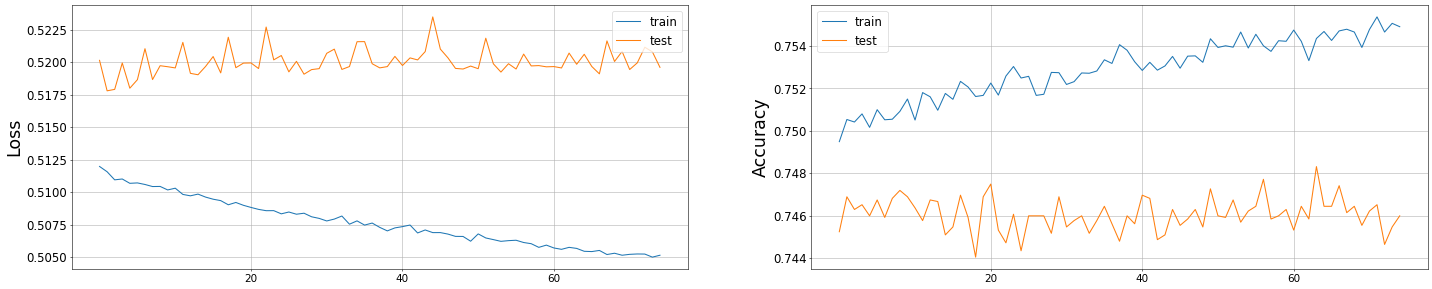

In [ ]:
"""
looking at the train/test loss and accuracy over the epochs
"""

width_in_inches = 35
height_in_inches = 7
dots_per_inch = 50

plt.figure(
    figsize=(width_in_inches, height_in_inches), dpi=dots_per_inch)

# PICK THE FOLD
fold = 5

# plot loss during training
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylabel('Loss', fontsize=25, color='black')
plt.xticks(range(20, len(history.history['loss'])+1, 20), fontsize=15, color='black')
plt.yticks(fontsize=17, color='black')
plt.legend(loc='upper right', fontsize=17)
plt.grid()
plt.savefig('/content/drive/My Drive/Official folder for Trashout/Task_1/models/final_model/meanencoding/train.png')

# plot accuracy during training
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.ylabel('Accuracy', fontsize=25, color='black')
plt.xticks(range(20, len(history.history['accuracy'])+1, 20), fontsize=15, color='black')
plt.yticks(fontsize=17, color='black')
plt.legend(fontsize=17)
plt.grid()
plt.savefig('/content/drive/My Drive/Official folder for Trashout/Task_1/models/final_model/meanencoding/test.png')

plt.show()

# ABANDONED Test 3 - distance to roads ordinal encoding

## ABANDONED - the performance accuracy of this variation was far below other models. The continuity of the distance to roads variable is a critically important variable for a good model.

In [ ]:
# training data
final = pd.read_csv('/content/drive/My Drive/Official folder for Trashout/Task_1/T1_Datasets/Final Datasets/Complete_dumpSites.csv')
print(f"final has shape {final.shape}")

final_random = pd.read_csv('/content/drive/My Drive/Official folder for Trashout/Task_1/T1_Datasets/Final Datasets/Complete_randomPoints_1km.csv')
print(f"final_random has shape {final_random.shape}")

# testing data
final_test = pd.read_csv('/content/drive/My Drive/Official folder for Trashout/Task_1/T1_Datasets/Final Datasets/Complete_dumpSites_Test.csv')
print(f"final_test has shape {final_test.shape}")

final_random_test = pd.read_csv('/content/drive/My Drive/Official folder for Trashout/Task_1/T1_Datasets/Final Datasets/Complete_randomPoints_1km_Test.csv')
print(f"final_random_test has shape {final_random_test.shape}")

final has shape (44881, 20)
final_random has shape (44545, 20)
final_test has shape (11217, 20)
final_random_test has shape (11133, 20)


## Generate Distance to Road Categories
Create 'roadDstBin' column based on following distance categories:
* 0 --> 0 <= x < 15, 
* 1 --> 15 <= x < 70, 
* 2 --> 70 <= x

Working on 4 datastes:
- final
- final_random 
- final_test 
- final_random_test

In [ ]:
final.loc[final['Distance to Road']<15,'RoadDstBin'] = 0
final.loc[(final['Distance to Road']>=15) & (final['Distance to Road']<70),'RoadDstBin'] = 1
final.loc[final['Distance to Road']>70,'RoadDstBin'] = 2

final

,TrashOutID,Lat,Lon,Continent,Distance to Road,Population Density,Population gradient,Distance to Nearest Venue,Number of Venues,Avg Dist to Venues,1stMostFreq,2ndMostFreq,3rdMostFreq,4thMostFreq,5thMostFreq,1stClosest,2ndClosest,3rdClosest,4thClosest,5thClosest,RoadDstBin
0,57837,-26.196481,28.050331,Africa,25.118444,12718.73,0.840314,332,24,706.25,Fast Food Restaurant,Portuguese Restaurant,Shopping Mall,Fried Chicken Joint,Hotel,Art Gallery,Shopping Mall,Convenience Store,Seafood Restaurant,Theater,1.0
1,57831,-28.466159,28.855491,Africa,16.073944,1704.99,0.714321,1500,0,3000.00,None,None,None,None,None,None,None,None,None,None,1.0
2,57830,-28.514575,28.820170,Africa,33.621466,3842.15,0.494658,496,4,620.00,Auto Workshop,Beer Garden,Restaurant,Gas Station,None,Restaurant,Gas Station,Auto Workshop,Beer Garden,None,1.0
3,57829,-29.947538,30.915913,Africa,32.739744,11928.59,0.327302,61,1,61.00,Shopping Mall,None,None,None,None,Shopping Mall,None,None,None,None,1.0
4,57817,-26.376726,27.300703,Africa,6.813308,2.17,0.493056,1500,0,3000.00,None,None,None,None,None,None,None,None,None,None,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44876,3271,-35.500999,-71.702774,South America,1.132428,117.51,0.000000,1500,0,3000.00,None,None,None,None,None,None,None,None,None,None,0.0
44877,2315,4.535037,-74.116149,South America,15.014083,6356.60,0.000000,332,5,536.40,Park,Big Box Store,Shopping Mall,Multiplex,Bus Station,Multiplex,Big Box Store,Shopping Mall,Bus Station,Park,1.0
44878,2280,4.534641,-74.115919,South America,22.447410,6356.60,0.000000,319,5,524.00,Park,Big Box Store,Shopping Mall,Multiplex,Bus Station,Multiplex,Big Box Store,Shopping Mall,Bus Station,Park,1.0
44879,1840,-25.524732,-49.107813,South America,9.966370,1088.07,0.772548,581,4,695.00,Soccer Field,Restaurant,Café,Trail,None,Soccer Field,Trail,Restaurant,Café,None,0.0


In [ ]:
final_random.loc[final_random['Distance to Road']<15,'RoadDstBin'] = 0
final_random.loc[(final_random['Distance to Road']>=15) & (final_random['Distance to Road']<70),'RoadDstBin'] = 1
final_random.loc[final_random['Distance to Road']>70,'RoadDstBin'] = 2

final_random

,TrashOutID,Lat,Lon,Continent,Distance to Road,Population Density,Population gradient,Distance to Nearest Venue,Number of Venues,Avg Dist to Venues,1stMostFreq,2ndMostFreq,3rdMostFreq,4thMostFreq,5thMostFreq,1stClosest,2ndClosest,3rdClosest,4thClosest,5thClosest,RoadDstBin
0,57836,-26.174340,27.985381,Africa,48.082264,4436.40,0.596904,420,5,607.600000,Restaurant,Shopping Mall,Supermarket,Tennis Court,Fast Food Restaurant,Tennis Court,Shopping Mall,Fast Food Restaurant,Supermarket,Restaurant,1.0
1,57831,-28.473954,28.859991,Africa,150.000000,2167.54,0.636909,1500,0,3000.000000,None,None,None,None,None,None,None,None,None,None,2.0
2,57830,-28.506780,28.815669,Africa,53.892441,3341.90,0.561918,634,3,757.666667,Construction & Landscaping,Gas Station,Restaurant,None,None,Restaurant,Gas Station,Construction & Landscaping,None,None,1.0
3,57828,-26.247996,27.703924,Africa,21.060757,5.65,0.499462,1500,0,3000.000000,None,None,None,None,None,None,None,None,None,None,1.0
4,57813,-26.022699,28.006938,Africa,10.986695,3039.87,0.360769,317,41,744.243902,Italian Restaurant,Hotel,Coffee Shop,Shopping Mall,Theater,Department Store,Zoo,Hotel,Comedy Club,Coffee Shop,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44540,4702,-15.485500,-43.458295,South America,150.000000,1.17,0.000000,1500,0,3000.000000,None,None,None,None,None,None,None,None,None,None,2.0
44541,4662,-30.006400,-51.185839,South America,49.525021,8626.26,0.608415,104,90,577.666667,Brazilian Restaurant,Gym / Fitness Center,Restaurant,Gymnastics Gym,Café,Big Box Store,Tattoo Parlor,Pie Shop,Fast Food Restaurant,Shopping Mall,1.0
44542,3693,-1.452680,-48.513001,South America,12.322144,0.00,0.500000,565,20,904.100000,Boat or Ferry,Historic Site,Plaza,Bar,History Museum,River,Bar,Boat or Ferry,Boat or Ferry,Music Venue,0.0
44543,2280,4.530140,-74.123714,South America,52.151224,6356.60,0.000000,519,5,669.800000,Bus Station,Multiplex,Shopping Mall,Big Box Store,Gas Station,Bus Station,Big Box Store,Shopping Mall,Multiplex,Gas Station,1.0


In [ ]:
final_test.loc[final_test['Distance to Road']<15,'RoadDstBin'] = 0
final_test.loc[(final_test['Distance to Road']>=15) & (final_test['Distance to Road']<70),'RoadDstBin'] = 1
final_test.loc[final_test['Distance to Road']>70,'RoadDstBin'] = 2

final_test

,TrashOutID,Lat,Lon,Continent,Distance to Road,Population Density,Population gradient,Distance to Nearest Venue,Number of Venues,Avg Dist to Venues,1stMostFreq,2ndMostFreq,3rdMostFreq,4thMostFreq,5thMostFreq,1stClosest,2ndClosest,3rdClosest,4thClosest,5thClosest,RoadDstBin
0,57836,-26.182135,27.989881,Africa,44.673641,3553.60,0.317897,341,5,654.200000,Bar,Tennis Court,Restaurant,Student Center,Bus Station,Restaurant,Bar,Student Center,Tennis Court,Bus Station,1.0
1,57828,-26.243496,27.696129,Africa,1.472705,314.45,0.923777,1500,0,3000.000000,None,None,None,None,None,None,None,None,None,None,0.0
2,57809,-26.241132,27.815810,Africa,9.143493,20422.59,0.343147,411,5,557.400000,Fish & Chips Shop,Japanese Restaurant,Dessert Shop,Bus Station,None,Fish & Chips Shop,Fish & Chips Shop,Bus Station,Dessert Shop,Japanese Restaurant,0.0
3,57764,-25.495246,31.179170,Africa,15.193524,1.18,0.499033,1500,0,3000.000000,None,None,None,None,None,None,None,None,None,None,1.0
4,57755,-26.230469,27.846345,Africa,2.803380,8480.55,0.315502,650,5,784.000000,Pub,Shopping Plaza,Café,Convenience Store,None,Pub,Café,Pub,Shopping Plaza,Convenience Store,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11212,10889,7.141387,-73.131985,South America,6.937212,4447.68,0.000000,361,2,649.500000,Snack Place,Factory,None,None,None,Factory,Snack Place,None,None,None,0.0
11213,10243,-33.042535,-71.552862,South America,6.086927,2473.31,0.015364,259,6,764.000000,Plaza,Stadium,Airport,Gym,Liquor Store,Trail,Stadium,Gym,Plaza,Airport,0.0
11214,8894,-33.598332,-70.683921,South America,8.446978,2616.26,0.178640,267,6,812.833333,Bus Station,Soccer Field,Flea Market,Concert Hall,Liquor Store,Bus Station,Concert Hall,Soccer Field,Bus Station,Flea Market,0.0
11215,8389,-16.523762,-68.112491,South America,4.406457,374.20,0.114832,253,12,744.083333,Pizza Place,Gym / Fitness Center,Gym Pool,Sports Bar,Park,Pizza Place,Pizza Place,Pizza Place,Breakfast Spot,Gym Pool,0.0


In [ ]:
final_random_test.loc[final_random_test['Distance to Road']<15,'RoadDstBin'] = 0
final_random_test.loc[(final_random_test['Distance to Road']>=15) & (final_random_test['Distance to Road']<70),'RoadDstBin'] = 1
final_random_test.loc[final_random_test['Distance to Road']>70,'RoadDstBin'] = 2

final_random_test

,TrashOutID,Lat,Lon,Continent,Distance to Road,Population Density,Population gradient,Distance to Nearest Venue,Number of Venues,Avg Dist to Venues,1stMostFreq,2ndMostFreq,3rdMostFreq,4thMostFreq,5thMostFreq,1stClosest,2ndClosest,3rdClosest,4thClosest,5thClosest,RoadDstBin
0,57837,-26.191981,28.042536,Africa,9.128174,45583.50,0.662325,258,44,687.136364,Coffee Shop,Fast Food Restaurant,Hotel,Art Gallery,Café,Historic Site,Theater,Art Gallery,Train Station,Hotel,0.0
1,57829,-29.938537,30.915913,Africa,2.136312,7893.65,0.622818,1500,0,3000.000000,None,None,None,None,None,None,None,None,None,None,0.0
2,57817,-26.385727,27.300703,Africa,150.000000,2.17,0.644543,1500,0,3000.000000,None,None,None,None,None,None,None,None,None,None,2.0
3,57777,-33.582348,18.468104,Africa,150.000000,9.18,0.440028,704,1,704.000000,Construction & Landscaping,None,None,None,None,Construction & Landscaping,None,None,None,None,2.0
4,57604,-33.905952,25.598207,Africa,6.882133,301.96,0.978314,375,4,642.000000,Grocery Store,Soccer Field,Fast Food Restaurant,Pub,None,Soccer Field,Pub,Fast Food Restaurant,Grocery Store,None,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11128,8389,-16.519261,-68.104696,South America,11.882514,374.20,0.000000,187,8,791.375000,Pizza Place,Gym / Fitness Center,Cable Car,Breakfast Spot,Park,Park,Cable Car,Pizza Place,Gym / Fitness Center,Pizza Place,0.0
11129,8247,-34.627745,-58.361550,South America,5.852983,10372.39,0.183187,268,71,787.647887,Argentinian Restaurant,Pizza Place,Restaurant,Italian Restaurant,BBQ Joint,Boat or Ferry,Farmers Market,Art Gallery,Restaurant,Bus Stop,0.0
11130,3271,-35.505499,-71.694979,South America,150.000000,117.51,0.000000,996,1,996.000000,Pet Store,None,None,None,None,Pet Store,None,None,None,None,2.0
11131,2315,4.539538,-74.108354,South America,4.292919,6356.60,0.000000,149,4,576.250000,Home Service,Grocery Store,Park,None,None,Park,Home Service,Grocery Store,Home Service,None,0.0


In [ ]:
# Drop the original Distance to Road column in each dataset
final = final.drop('Distance to Road',axis=1)
final_random = final_random.drop('Distance to Road',axis=1)
final_test = final_test.drop('Distance to Road',axis=1)
final_random_test = final_random_test.drop('Distance to Road',axis=1)

In [ ]:
"""
removing null values from Continent variables
"""

final = final[final['Continent'].notna()]
final_random = final_random[final_random['Continent'].notna()]

final_test = final_test[final_test['Continent'].notna()]
final_random_test = final_random_test[final_random_test['Continent'].notna()]

In [ ]:
final['Continent'].isnull().any(), final_random['Continent'].isnull().any(), final_test['Continent'].isnull().any(), final_random_test['Continent'].isnull().any()

# great, null values removed from Continent of all four datasets

(False, False, False, False)

In [ ]:
final['RoadDstBin'].isnull().any(), final_random['RoadDstBin'].isnull().any(), final_test['RoadDstBin'].isnull().any(), final_random_test['RoadDstBin'].isnull().any()

# great, null values removed from RoadDstBin of all four datasets

(False, False, False, False)

In [ ]:
# do we need this / what does this do? 
set(final['RoadDstBin']), set(final_random['RoadDstBin']), set(final_test['RoadDstBin']), set(final_random_test['RoadDstBin'])

({0.0, 1.0, 2.0}, {0.0, 1.0, 2.0}, {0.0, 1.0, 2.0}, {0.0, 1.0, 2.0})

In [ ]:
len(set(final['RoadDstBin'])), len(set(final_random['RoadDstBin'])), len(set(final_test['RoadDstBin'])), len(set(final_random_test['RoadDstBin']))

(3, 3, 3, 3)

In [ ]:
"""
adding target labels
"""

if 'target' not in final.columns + final_random.columns:
    final['target'] = 1
    final_random['target'] = 0

if 'target' not in final_test.columns + final_random_test.columns:
    final_test['target'] = 1
    final_random_test['target'] = 0

In [ ]:
final

,TrashOutID,Lat,Lon,Continent,Population Density,Population gradient,Distance to Nearest Venue,Number of Venues,Avg Dist to Venues,1stMostFreq,2ndMostFreq,3rdMostFreq,4thMostFreq,5thMostFreq,1stClosest,2ndClosest,3rdClosest,4thClosest,5thClosest,RoadDstBin,target
0,57837,-26.196481,28.050331,Africa,12718.73,0.840314,332,24,706.25,Fast Food Restaurant,Portuguese Restaurant,Shopping Mall,Fried Chicken Joint,Hotel,Art Gallery,Shopping Mall,Convenience Store,Seafood Restaurant,Theater,1.0,1
1,57831,-28.466159,28.855491,Africa,1704.99,0.714321,1500,0,3000.00,None,None,None,None,None,None,None,None,None,None,1.0,1
2,57830,-28.514575,28.820170,Africa,3842.15,0.494658,496,4,620.00,Auto Workshop,Beer Garden,Restaurant,Gas Station,None,Restaurant,Gas Station,Auto Workshop,Beer Garden,None,1.0,1
3,57829,-29.947538,30.915913,Africa,11928.59,0.327302,61,1,61.00,Shopping Mall,None,None,None,None,Shopping Mall,None,None,None,None,1.0,1
4,57817,-26.376726,27.300703,Africa,2.17,0.493056,1500,0,3000.00,None,None,None,None,None,None,None,None,None,None,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44876,3271,-35.500999,-71.702774,South America,117.51,0.000000,1500,0,3000.00,None,None,None,None,None,None,None,None,None,None,0.0,1
44877,2315,4.535037,-74.116149,South America,6356.60,0.000000,332,5,536.40,Park,Big Box Store,Shopping Mall,Multiplex,Bus Station,Multiplex,Big Box Store,Shopping Mall,Bus Station,Park,1.0,1
44878,2280,4.534641,-74.115919,South America,6356.60,0.000000,319,5,524.00,Park,Big Box Store,Shopping Mall,Multiplex,Bus Station,Multiplex,Big Box Store,Shopping Mall,Bus Station,Park,1.0,1
44879,1840,-25.524732,-49.107813,South America,1088.07,0.772548,581,4,695.00,Soccer Field,Restaurant,Café,Trail,None,Soccer Field,Trail,Restaurant,Café,None,0.0,1


In [ ]:
"""
making the continent into one-hot encoding for both datasets
"""

train_dumpsite_dummies = pd.get_dummies(final['Continent'])
final = pd.concat([final.drop('Continent', axis=1), train_dumpsite_dummies], axis=1)

train_nondumpsite_dummies = pd.get_dummies(final_random['Continent'])
final_random = pd.concat([final_random.drop('Continent', axis=1), train_nondumpsite_dummies], axis=1)

test_dumpsite_dummies = pd.get_dummies(final_test['Continent'])
final_test = pd.concat([final_test.drop('Continent', axis=1), test_dumpsite_dummies], axis=1)

test_nondumpsite_dummies = pd.get_dummies(final_random_test['Continent'])
final_random_test = pd.concat([final_random_test.drop('Continent', axis=1), test_nondumpsite_dummies], axis=1)

## Using LeaveOneOut encoding on the venue categories.

In [ ]:
# combined data of dumpsites and non-dumpsites in train and test sets

data = pd.concat([final, final_random], axis=0)

data_test = pd.concat([final_test, final_random_test], axis=0)

In [ ]:
"""
Applying an encoding onto the 10 different columns (#thMostFreq and #thClosest) categorical variables
"""

columns = ['1stMostFreq', '2ndMostFreq', '3rdMostFreq', '4thMostFreq', '5thMostFreq', '1stClosest', '2ndClosest', '3rdClosest', '4thClosest', '5thClosest']

for col in columns: 
  # training
  leaveoneoutenc = ce.LeaveOneOutEncoder(return_df=True)
  leaveoneoutenc.fit(X=data[col], y=data['target'])

  data[col + 'leaveoneout_enc'] = leaveoneoutenc.transform(data[col])
  data.drop([col], axis=1, inplace=True)
  
  #testing
  data_test[col + 'leaveoneout_enc'] = leaveoneoutenc.transform(data_test[col])
  data_test.drop([col], axis=1, inplace=True)
  data_test.head()

data.drop('TrashOutID', axis=1, inplace=True)
data_test.drop('TrashOutID', axis=1, inplace=True)

In [ ]:
"""
removing any null values in other variables
"""

data.dropna(inplace=True)
data_test.dropna(inplace=True)

data.shape, data_test.shape

((88916, 26), (22222, 26))

## Building a Model (leave one out encoding)

In [ ]:
"""
training and testing separation
"""

X = data.drop(['target'], axis=1).to_numpy()
Y = data['target'].to_numpy()

test_x = data_test.drop(['target'], axis=1).to_numpy()
test_y = data_test['target'].to_numpy()

using_kfold = True

if not using_kfold:
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,
                                                    stratify=Y,
                                                    random_state=111)
  print(f"X_train is {X_train.shape}", f"X_test is {X_test.shape}")

else:
  X_train = X
  Y_train = Y
  print(f"X_train is {X_train.shape}", f"Y_train is {Y_train.shape}")

('X_train is (71132, 25)', 'X_test is (17784, 25)')

In [ ]:
"""
normalizing the continuous variables
"""

scaler = StandardScaler()

scaler.fit(X_train[:, :6])

X_train[:, :6] = scaler.transform(X_train[:, :6])

if not using_kfold:
  X_test[:, :6] = scaler.transform(X_test[:, :6]) 
  print(f"X_train is {X_train.shape}", f"X_test is {X_test.shape}")
else:
  X_train.shape

('X_train is (71132, 25)', 'X_test is (17784, 25)')

In [ ]:
"""
building the model
"""

x_input = Input(shape=(X_train.shape[-1],), name='continuous_input')

x = Dense(units=32, activation='relu', name=f'dense_1',
          kernel_regularizer=regularizers.l2(1e-4))(x_input)

# x = Dropout(rate=0.2, name=f'dropout_1')(x)

for i, unit in enumerate([32, 32], start=2):
    x = Dense(units=unit, activation='relu', name=f'dense_{i}',
              kernel_regularizer=regularizers.l2(1e-4))(x)
    
    # x = BatchNormalization(name=f'batchnorm_{i}')(x)
    # x = Dropout(rate=0.2, name=f'dropout_{i}')(x)

out = Dense(units=1, activation='sigmoid', name='output_layer')(x)

model = Model(inputs=x_input, outputs=out, name='Dumpsite_Prediction_Model')

# saving the model graph and seeing the architecture 
plot_model(model, show_shapes=True, to_file='/content/drive/My Drive/Official folder for Trashout/Task_1/models/simone/final_model/leaveoneoutencoding/nn_graph.png')

model.summary()

Model: "Dumpsite_Prediction_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
continuous_input (InputLayer [(None, 25)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                832       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
output_layer (Dense)         (None, 1)                 33        
Total params: 2,977
Trainable params: 2,977
Non-trainable params: 0
_________________________________________________________________


## Using K-Fold for better learning

In [ ]:
"""
using the sklearn library to split the training data
into folds of training and validation splits
"""

n_split=10

fold = StratifiedShuffleSplit(n_splits=n_split, test_size=0.15, random_state=111)

train_acc=[]
train_loss=[]
val_acc=[]
val_loss=[]

fold.get_n_splits(X_train, Y_train)

10

## Training for Leaveoneout encoding

In [ ]:
"""
compiling and fitting
"""

filepath_curr = '/content/drive/My Drive/Official folder for Trashout/Task_1/models/simone/final_model/leaveoneoutencoding/curr_model.h5'

checkpoint = ModelCheckpoint(filepath=filepath_curr, monitor='val_accuracy', save_best_only=True)

opts = Adam(learning_rate=0.001, epsilon=1e-8, decay=0.0001)

# model will begin training with previously trained weights
try:
    model.load_weights(filepath_curr)
    print('Same architecture as before.\n\n')
except:
    print('Model architecture has been changed. No weights loaded.\n\n')

i = 1 # counter for print statement

if not using_kfold:
  model.compile(optimizer=opts, loss='binary_crossentropy', metrics=['accuracy'])
  history = model.fit(
      X_train,
      Y_train,
      batch_size=128,
      epochs=75,
      validation_data=(X_test, Y_test),
      callbacks=[checkpoint],
      verbose=2
  )
else:
  for train_index, val_index in fold.split(X_train, Y_train):

      train_x, val_x = X_train[train_index], X_train[val_index]
      train_y, val_y = Y_train[train_index], Y_train[val_index]

      model.compile(optimizer=opts, loss='binary_crossentropy', metrics=['accuracy'])
          
      history = model.fit(
          train_x,
          train_y,
          batch_size=128,
          epochs=75,
          validation_data=(val_x, val_y),
          callbacks=[checkpoint],
          verbose=0
      )

      curr_train_acc = round(model.evaluate(train_x, train_y, verbose=0)[1]*100, 2)
      curr_val_acc = round(model.evaluate(val_x, val_y, verbose=0)[1]*100, 2)

      curr_train_loss = model.evaluate(train_x, train_y, verbose=0)[0]
      curr_val_loss = model.evaluate(val_x, val_y, verbose=0)[0]

      print("-"*75)
      print(f"Fold {i}: train acc = {curr_train_acc}%")
      print(f"Fold {i}: val acc = {curr_val_acc}%")
      print("-"*75 + "\n\n")

      train_acc.append(curr_train_acc)
      val_acc.append(curr_val_acc)
      train_loss.append(curr_train_loss)
      val_loss.append(curr_val_loss)

      i += 1

Same architecture as before.




---------------------------------------------------------------------------
Fold 1: train acc = 77.71%
Fold 1: val acc = 76.48%
---------------------------------------------------------------------------




---------------------------------------------------------------------------
Fold 2: train acc = 77.95%
Fold 2: val acc = 76.69%
---------------------------------------------------------------------------




---------------------------------------------------------------------------
Fold 3: train acc = 77.94%
Fold 3: val acc = 77.21%
---------------------------------------------------------------------------




---------------------------------------------------------------------------
Fold 4: train acc = 78.24%
Fold 4: val acc = 76.63%
---------------------------------------------------------------------------




---------------------------------------------------------------------------
Fold 5: train acc = 78.26%
Fold 5: val acc = 76.91%
-------

## Evaluating average accuracy and loss after K-Fold

In [ ]:
if using_kfold:
  for i, v in enumerate(train_acc, start=0):
    print('-'*50)
    print(f'Fold {i+1} - Train Loss: {train_loss[i]} - Train Accuracy: {train_acc[i]}%')
    print(f'Fold {i+1} - Validation Loss: {val_loss[i]} - Validation Accuracy: {val_acc[i]}%')

  print('-'*50)

  print('\n\nAverage scores for all folds:\n\n')
  # training
  print(f'Train Accuracy: {round(np.mean(train_acc), 2)} +- {round(np.std(train_acc), 2)}')
  print(f'Train Loss: {round(np.mean(train_loss), 3)}')
  # validation
  print(f'\n\nTest Accuracy: {round(np.mean(val_acc), 2)} +- {round(np.std(val_acc), 2)}')
  print(f'Test Loss: {round(np.mean(val_loss), 3)}')

--------------------------------------------------
Fold 1 - Train Loss: 0.46685877442359924 - Train Accuracy: 77.71%
Fold 1 - Validation Loss: 0.49640798568725586 - Validation Accuracy: 76.48%
--------------------------------------------------
Fold 2 - Train Loss: 0.4645579159259796 - Train Accuracy: 77.95%
Fold 2 - Validation Loss: 0.47994858026504517 - Validation Accuracy: 76.69%
--------------------------------------------------
Fold 3 - Train Loss: 0.46177178621292114 - Train Accuracy: 77.94%
Fold 3 - Validation Loss: 0.47899767756462097 - Validation Accuracy: 77.21%
--------------------------------------------------
Fold 4 - Train Loss: 0.4592919945716858 - Train Accuracy: 78.24%
Fold 4 - Validation Loss: 0.48363110423088074 - Validation Accuracy: 76.63%
--------------------------------------------------
Fold 5 - Train Loss: 0.45811691880226135 - Train Accuracy: 78.26%
Fold 5 - Validation Loss: 0.4815528988838196 - Validation Accuracy: 76.91%
--------------------------------------

In [ ]:
"""
this code takes care of saving the new model only if its accuracy is better than
that of the last model
"""

filepath = '/content/drive/My Drive/Official folder for Trashout/Task_1/models/simone/final_model/leaveoneoutencoding/best_model.h5'
filepath_curr = '/content/drive/My Drive/Official folder for Trashout/Task_1/models/simone/final_model/leaveoneoutencoding/curr_model.h5'


if os.path.exists(filepath):
  prev_model = load_model(filepath)
  curr_model = load_model(filepath_curr)

  prev_acc = prev_model.evaluate(test_x, test_y, verbose=0)[1]
  curr_acc = curr_model.evaluate(test_x, test_y, verbose=0)[1]

  if curr_acc > prev_acc:
    print("There was a previous model saved.\n")
    print(f"Previous test accuracy: {round(prev_acc*100, 2)}%")
    print(f"Current test accuracy: {round(curr_acc*100, 2)}%")
    curr_model.save(filepath)
    print('\nNew model is saved.')
  else:
    print(f"Previous test accuracy: {round(prev_acc*100, 2)}%")
    print(f"Current test accuracy: {round(curr_acc*100, 2)}%")
    print('Old model is kept.')

else: # if this is the first time saving the model
  model.save(filepath)
  curr_model = load_model(filepath)
  curr_acc = curr_model.evaluate(test_x, test_y, verbose=0)[1]
  print(f"Current test accuracy: {round(curr_acc*100, 2)}%")
  print('\nFirst time model is saved.')

There was a previous model saved.

Previous test accuracy: 49.01%
Current test accuracy: 49.99%

New model is saved.


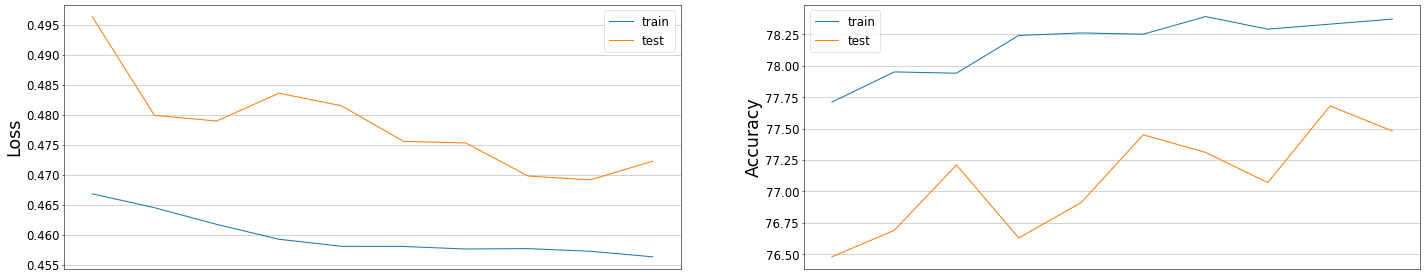

In [ ]:
"""
looking at the train/test loss and accuracy over the epochs
"""

width_in_inches = 35
height_in_inches = 7
dots_per_inch = 50

plt.figure(
    figsize=(width_in_inches, height_in_inches), dpi=dots_per_inch)

# PICK THE FOLD
fold = 5

# plot loss during training
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylabel('Loss', fontsize=25, color='black')
plt.xticks(range(20, len(history.history['loss'])+1, 20), fontsize=15, color='black')
plt.yticks(fontsize=17, color='black')
plt.legend(loc='upper right', fontsize=17)
plt.grid()
plt.savefig('/content/drive/My Drive/Official folder for Trashout/Task_1/models/final_model/meanencoding/train.png')

# plot accuracy during training
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.ylabel('Accuracy', fontsize=25, color='black')
plt.xticks(range(20, len(history.history['accuracy'])+1, 20), fontsize=15, color='black')
plt.yticks(fontsize=17, color='black')
plt.legend(fontsize=17)
plt.grid()
plt.savefig('/content/drive/My Drive/Official folder for Trashout/Task_1/models/final_model/meanencoding/test.png')

plt.show()

In [ ]:
"""
printing the confusion matrix
"""

preds = load_model(filepath).predict(test_x).squeeze()

assert preds.shape == test_y.shape, 'The shapes of the two tensors are unequal'

print(confusion_matrix(test_y, np.round(preds)))

print(classification_report(test_y, np.round(preds)))

[[  172 10868]
 [  246 10936]]
              precision    recall  f1-score   support

           0       0.41      0.02      0.03     11040
           1       0.50      0.98      0.66     11182

    accuracy                           0.50     22222
   macro avg       0.46      0.50      0.35     22222
weighted avg       0.46      0.50      0.35     22222



# Test 4 - Data variation between dumpsites and non-dumpsites

## Could be structured so as to change the 50/50 ratio between dumpsites and non-dumpsites dataset. Two possible variabtions to get started with

1. More dumpsite data than non-dumpsite data - **Reasoning could be that our model should be good at detecting dumpsites, hence it needs to learn what they look like**.

2. Less dumpsite than than non-dumpsite data - **More closely related to what the data would probably look like in the real world.**

Both variations need to be tested. However, **first variation is more sensible on a preliminary logical approach (opinion) and should be given priority to tune**.

In [ ]:
# training data
final_bal = final.copy()

final_random_bal = final_random.copy()

# testing data
final_test_bal = final_test.copy()

final_random_test_bal = final_random_test.copy() 

In [ ]:
final_bal.shape, final_random_bal.shape, final_test_bal.shape, final_random_test_bal.shape

((44841, 27), (44505, 27), (11207, 27), (11123, 27))

In [ ]:
final_bal.head()

,TrashOutID,Lat,Lon,Distance to Road,Population Density,Population gradient,Distance to Nearest Venue,Number of Venues,Avg Dist to Venues,1stMostFreq,2ndMostFreq,3rdMostFreq,4thMostFreq,5thMostFreq,1stClosest,2ndClosest,3rdClosest,4thClosest,5thClosest,Africa,Asia,Australia,Europe,North America,Oceania,South America,target
0,57837,-26.196481,28.050331,25.118444,12718.73,0.840314,332,24,706.25,Fast Food Restaurant,Portuguese Restaurant,Shopping Mall,Fried Chicken Joint,Hotel,Art Gallery,Shopping Mall,Convenience Store,Seafood Restaurant,Theater,1,0,0,0,0,0,0,1
1,57831,-28.466159,28.855491,16.073944,1704.99,0.714321,1500,0,3000.00,None,None,None,None,None,None,None,None,None,None,1,0,0,0,0,0,0,1
2,57830,-28.514575,28.820170,33.621466,3842.15,0.494658,496,4,620.00,Auto Workshop,Beer Garden,Restaurant,Gas Station,None,Restaurant,Gas Station,Auto Workshop,Beer Garden,None,1,0,0,0,0,0,0,1
3,57829,-29.947538,30.915913,32.739744,11928.59,0.327302,61,1,61.00,Shopping Mall,None,None,None,None,Shopping Mall,None,None,None,None,1,0,0,0,0,0,0,1
4,57817,-26.376726,27.300703,6.813308,2.17,0.493056,1500,0,3000.00,None,None,None,None,None,None,None,None,None,None,1,0,0,0,0,0,0,1


## Reduce the size of the training random dumpsites dataset


In [ ]:
final_random_bal = final_random_bal.sample(frac = 1.0)
final_bal = final_bal.sample(frac = 1.0)

print(final_bal.shape, final_random_bal.shape)
final_test_bal.shape, final_random_test_bal.shape

(44841, 27) (44505, 27)


((11207, 27), (11123, 27))

In [ ]:
final_bal.head()

,TrashOutID,Lat,Lon,Distance to Road,Population Density,Population gradient,Distance to Nearest Venue,Number of Venues,Avg Dist to Venues,1stMostFreq,2ndMostFreq,3rdMostFreq,4thMostFreq,5thMostFreq,1stClosest,2ndClosest,3rdClosest,4thClosest,5thClosest,Africa,Asia,Australia,Europe,North America,Oceania,South America,target
20081,30320,41.832613,19.661985,1.673061,94.16,0.000903,1500,0,3000.000000,None,None,None,None,None,None,None,None,None,None,0,0,0,1,0,0,0,1
39086,743,48.246214,17.284035,1.990003,235.77,0.292847,625,4,782.250000,Slovak Restaurant,Restaurant,Soccer Field,None,None,Restaurant,Soccer Field,Slovak Restaurant,Slovak Restaurant,None,0,0,0,1,0,0,0,1
12632,42040,41.600443,19.668775,2.326226,257.21,0.000000,1500,0,3000.000000,None,None,None,None,None,None,None,None,None,None,0,0,0,1,0,0,0,1
10349,45693,41.210574,-8.562719,11.930083,9742.34,0.447761,245,29,671.000000,Bakery,Park,Supermarket,Bar,Stadium,Convenience Store,Supermarket,Gas Station,Dumpling Restaurant,Supermarket,0,0,0,1,0,0,0,1
35943,5556,48.146982,17.076084,1.412669,3655.20,0.066986,216,28,629.285714,Restaurant,Hotel,Pub,Café,Beach,Botanical Garden,Tennis Court,Gym,Soccer Field,Restaurant,0,0,0,1,0,0,0,1


In [ ]:
class Myobj:
    def __init__(self):
        self.user = user
        self.add = 'really '
        self.i = 1
    
    def dostuff(self):
        self.user = input("Do you want to use this program(y/n): ")
        while self.user.lower() != 'y':
            self.user = input(f"Are you {self.add * self.i}sure that you do not want to use this program? ")
            self.i += 1
        print("\nIt's not like this does something lol")

binod = Myobj().dostuff()

In [ ]:
# combined data of dumpsites and non-dumpsites in train and test sets

data_bal = pd.concat([final_bal, final_random_bal], axis=0)

data_test_bal = pd.concat([final_test_bal, final_random_test_bal], axis=0)

In [ ]:
data_bal.drop(['3rdMostFreq', '4thMostFreq', '5thMostFreq',
               '3rdClosest', '4thClosest', '5thClosest'], axis=1, inplace=True)
data_test_bal.drop(['3rdMostFreq', '4thMostFreq', '5thMostFreq',
               '3rdClosest', '4thClosest', '5thClosest'], axis=1, inplace=True)

In [ ]:
data_bal.head()

,TrashOutID,Lat,Lon,Distance to Road,Population Density,Population gradient,Distance to Nearest Venue,Number of Venues,Avg Dist to Venues,1stMostFreq,2ndMostFreq,1stClosest,2ndClosest,Africa,Asia,Australia,Europe,North America,Oceania,South America,target
20081,30320,41.832613,19.661985,1.673061,94.16,0.000903,1500,0,3000.000000,None,None,None,None,0,0,0,1,0,0,0,1
39086,743,48.246214,17.284035,1.990003,235.77,0.292847,625,4,782.250000,Slovak Restaurant,Restaurant,Restaurant,Soccer Field,0,0,0,1,0,0,0,1
12632,42040,41.600443,19.668775,2.326226,257.21,0.000000,1500,0,3000.000000,None,None,None,None,0,0,0,1,0,0,0,1
10349,45693,41.210574,-8.562719,11.930083,9742.34,0.447761,245,29,671.000000,Bakery,Park,Convenience Store,Supermarket,0,0,0,1,0,0,0,1
35943,5556,48.146982,17.076084,1.412669,3655.20,0.066986,216,28,629.285714,Restaurant,Hotel,Botanical Garden,Tennis Court,0,0,0,1,0,0,0,1


## Encoding for venue categories

In [ ]:
#@title # Transform the Venue categories by picking an encoding below
"""
Applying an encoding onto the 10 different columns (#thMostFreq and #thClosest) categorical variables
"""

encoding = "LeaveOneOut" #@param ["LeaveOneOut", "Frequency", "Mean"]

columns = ['1stMostFreq', '2ndMostFreq',
           '1stClosest', '2ndClosest']

if encoding.lower() == 'leaveoneout':
    for col in columns: 
        # training
        leaveoneoutenc = ce.LeaveOneOutEncoder(return_df=True)
        leaveoneoutenc.fit(X=data_bal[col], y=data_bal['target'])

        data_bal[col + 'leaveoneout_enc'] = leaveoneoutenc.transform(data_bal[col])
        data_bal.drop([col], axis=1, inplace=True)
        
        #testing
        data_test_bal[col + 'leaveoneout_enc'] = leaveoneoutenc.transform(data_test_bal[col])
        data_test_bal.drop([col], axis=1, inplace=True)
        data_test_bal.head()

    data_bal.drop(['TrashOutID', 'Lat', 'Lon'], axis=1, inplace=True)
    data_test_bal.drop(['TrashOutID', 'Lat', 'Lon'], axis=1, inplace=True)

elif encoding.lower() == 'frequency':
    for col in columns:
        freq = data_bal.groupby(col).size() / len(data_bal)
        # training
        data_bal[col + 'frequency_enc'] = data_bal[col].map(freq)
        data_bal.drop([col], axis=1, inplace=True)
        
        #testing
        data_test_bal[col + 'frequency_enc'] = data_test_bal[col].map(freq)
        data_test_bal.drop([col], axis=1, inplace=True)

    data_bal.drop(['TrashOutID', 'Lat', 'Lon'], axis=1, inplace=True)
    data_test_bal.drop(['TrashOutID', 'Lat', 'Lon'], axis=1, inplace=True)

elif encoding.lower() == 'mean':
        class MultiColumnEncoder:
            def __init__(self, columns=None):
                self.columns = columns # array of column names to encode

            def fit_transform(self, X, test_set):
                mean = X['target'].mean()
                if self.columns is not None:
                    for col in self.columns:
                        agg= X.groupby(col)['target'].agg(['count','mean'])
                        counts=agg['count']
                        means=agg['mean']
                        weight=100
                        smooth = (counts*means +weight *mean) / (counts + weight)
                        X.loc[:, col+'_mean'] = X[col].map(smooth)
                        test_set.loc[:, col+'_mean'] = test_set[col].map(smooth)
                X.drop(self.columns,axis=1,inplace=True)
                test_set.drop(self.columns,axis=1,inplace=True)
                return X
        mc_class = MultiColumnEncoder(columns)
        data_bal = mc_class.fit_transform(data_bal, data_test_bal)
        data_bal.drop(['Lat', 'Lon', 'TrashOutID'], axis=1, inplace=True)
        data_test_bal.drop(['Lat', 'Lon', 'TrashOutID'], axis=1, inplace=True)

In [ ]:
data_bal.head()

,Distance to Road,Population Density,Population gradient,Distance to Nearest Venue,Number of Venues,Avg Dist to Venues,Africa,Asia,Australia,Europe,North America,Oceania,South America,target,1stMostFreqleaveoneout_enc,2ndMostFreqleaveoneout_enc,1stClosestleaveoneout_enc,2ndClosestleaveoneout_enc
20081,1.673061,94.16,0.000903,1500,0,3000.000000,0,0,0,1,0,0,0,1,0.454633,0.465707,0.454633,0.465283
39086,1.990003,235.77,0.292847,625,4,782.250000,0,0,0,1,0,0,0,1,0.372093,0.490300,0.538086,0.541401
12632,2.326226,257.21,0.000000,1500,0,3000.000000,0,0,0,1,0,0,0,1,0.454633,0.465707,0.454633,0.465283
10349,11.930083,9742.34,0.447761,245,29,671.000000,0,0,0,1,0,0,0,1,0.522624,0.580357,0.539773,0.582245
35943,1.412669,3655.20,0.066986,216,28,629.285714,0,0,0,1,0,0,0,1,0.561388,0.582879,0.348315,0.621469


In [ ]:
#@markdown ## Removing NaN values
"""
removing any null values in other variables
"""

print(data_bal.shape, data_test_bal.shape)

data_bal.dropna(inplace=True)
data_test_bal.dropna(inplace=True)

data_bal.shape, data_test_bal.shape

(89346, 18) (22330, 18)


((88916, 18), (22222, 18))

## Build the model

In [ ]:
"""
training and testing separation
"""

X = data_bal.drop(['target'], axis=1).to_numpy()
Y = data_bal['target'].to_numpy()

test_x = data_test_bal.drop(['target'], axis=1).to_numpy()
test_y = data_test_bal['target'].to_numpy()

using_kfold = False

if not using_kfold:
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,
                                                    stratify=Y,
                                                    random_state=111)
  print(f"X_train is {X_train.shape}", f"X_test is {X_test.shape}")

else:
  X_train = X
  Y_train = Y
  print(f"X_train is {X_train.shape}", f"Y_train is {Y_train.shape}")

X_train is (71132, 17) X_test is (17784, 17)


In [ ]:
"""
normalizing the continuous variables
"""

scaler = StandardScaler()

scaler.fit(X_train[:, :6])

X_train[:, :6] = scaler.transform(X_train[:, :6])

if not using_kfold:
  X_test[:, :6] = scaler.transform(X_test[:, :6]) 
  print(f"X_train is {X_train.shape}", f"X_test is {X_test.shape}")
else:
  X_train.shape

X_train is (71132, 17) X_test is (17784, 17)


In [ ]:
"""
building the model
"""

x_input = Input(shape=(X_train.shape[-1],), name='continuous_input')

x = Dense(units=16, activation='relu', name=f'dense_1',
          kernel_regularizer=regularizers.l2(1e-3),
          activity_regularizer=regularizers.l2(1e-3))(x_input)

# x = BatchNormalization(name=f'batchnorm_1')(x)
x = Dropout(rate=0.5, name=f'dropout_1')(x)

for i, unit in enumerate([16], start=2):
    x = Dense(units=unit, activation='relu', name=f'dense_{i}',
              kernel_regularizer=regularizers.l2(1e-3),
              activity_regularizer=regularizers.l2(1e-3))(x)
    
    # x = BatchNormalization(name=f'batchnorm_{i}')(x)
    x = Dropout(rate=0.5, name=f'dropout_{i}')(x)

out = Dense(units=1, activation='sigmoid', name='output_layer')(x)

model = Model(inputs=x_input, outputs=out, name='Dumpsite_Prediction_Model')

# saving the model graph and seeing the architecture 
plot_model(model, show_shapes=True, to_file='/content/drive/My Drive/Official folder for Trashout/Task_1/models/pedro/final_model/nn_graph.png')

model.summary()

Model: "Dumpsite_Prediction_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
continuous_input (InputLayer [(None, 17)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                288       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 17        
Total params: 577
Trainable params: 577
Non-trainable params: 0
___________________________________________

## Using K-Fold for better learning

In [ ]:
"""
using the sklearn library to split the training data
into folds of training and validation splits
"""

n_split=10

fold = StratifiedShuffleSplit(n_splits=n_split, test_size=0.15,
                               random_state=111)

train_acc=[]
train_loss=[]
val_acc=[]
val_loss=[]

fold.get_n_splits(X_train, Y_train)

10

## Training


In [ ]:
"""
compiling and fitting
"""

filepath_curr = '/content/drive/My Drive/Official folder for Trashout/Task_1/models/pedro/final_model/curr_model.h5'

checkpoint = ModelCheckpoint(filepath=filepath_curr, monitor='val_accuracy', save_best_only=True)

opts = Adam(learning_rate=0.001, epsilon=1e-8, decay=0.000005)

# model will begin training with previously trained weights
try:
    model.load_weights(filepath_curr)
    print('Same architecture as before.\n\n')
except:
    print('Model architecture has been changed. No weights loaded.\n\n')

i = 1 # counter for print statement

if not using_kfold:
  model.compile(optimizer=opts, loss='binary_crossentropy', metrics=['accuracy'])
  history = model.fit(
      X_train,
      Y_train,
      batch_size=128,
      epochs=100,
      validation_data=(X_test, Y_test),
      callbacks=[checkpoint],
      verbose=2
  )
else:
  for train_index, val_index in fold.split(X_train, Y_train):

      train_x, val_x = X_train[train_index], X_train[val_index]
      train_y, val_y = Y_train[train_index], Y_train[val_index]

      model.compile(optimizer=opts, loss='binary_crossentropy', metrics=['accuracy'])
          
      history = model.fit(
          train_x,
          train_y,
          batch_size=128,
          epochs=75,
          validation_data=(val_x, val_y),
          callbacks=[checkpoint],
          verbose=0
      )

      curr_train_acc = round(model.evaluate(train_x, train_y, verbose=0)[1]*100, 2)
      curr_val_acc = round(model.evaluate(val_x, val_y, verbose=0)[1]*100, 2)

      curr_train_loss = model.evaluate(train_x, train_y, verbose=0)[0]
      curr_val_loss = model.evaluate(val_x, val_y, verbose=0)[0]

      print("-"*75)
      print(f"Fold {i}: train acc = {curr_train_acc}%")
      print(f"Fold {i}: val acc = {curr_val_acc}%")
      print("-"*75 + "\n\n")

      train_acc.append(curr_train_acc)
      val_acc.append(curr_val_acc)
      train_loss.append(curr_train_loss)
      val_loss.append(curr_val_loss)

      i += 1

Model architecture has been changed. No weights loaded.


Epoch 1/100
556/556 - 1s - loss: 0.7037 - accuracy: 0.5820 - val_loss: 0.6508 - val_accuracy: 0.6606
Epoch 2/100
556/556 - 1s - loss: 0.6541 - accuracy: 0.6488 - val_loss: 0.6292 - val_accuracy: 0.6709
Epoch 3/100
556/556 - 1s - loss: 0.6382 - accuracy: 0.6655 - val_loss: 0.6100 - val_accuracy: 0.6771
Epoch 4/100
556/556 - 1s - loss: 0.6244 - accuracy: 0.6757 - val_loss: 0.5975 - val_accuracy: 0.6894
Epoch 5/100
556/556 - 1s - loss: 0.6173 - accuracy: 0.6810 - val_loss: 0.5905 - val_accuracy: 0.7005
Epoch 6/100
556/556 - 1s - loss: 0.6094 - accuracy: 0.6889 - val_loss: 0.5849 - val_accuracy: 0.7062
Epoch 7/100
556/556 - 1s - loss: 0.6062 - accuracy: 0.6917 - val_loss: 0.5796 - val_accuracy: 0.7104
Epoch 8/100
556/556 - 1s - loss: 0.6021 - accuracy: 0.6980 - val_loss: 0.5762 - val_accuracy: 0.7174
Epoch 9/100
556/556 - 1s - loss: 0.6003 - accuracy: 0.6982 - val_loss: 0.5731 - val_accuracy: 0.7151
Epoch 10/100
556/556 - 1s - loss:

## Evaluating average accuracy and loss after K-Fold

In [ ]:
if using_kfold:
  for i, v in enumerate(train_acc, start=0):
    print('-'*50)
    print(f'Fold {i+1} - Train Loss: {train_loss[i]} - Train Accuracy: {train_acc[i]}%')
    print(f'Fold {i+1} - Validation Loss: {val_loss[i]} - Validation Accuracy: {val_acc[i]}%')

  print('-'*50)

  print('\n\nAverage scores for all folds:\n\n')
  # training
  print(f'Train Accuracy: {round(np.mean(train_acc), 2)} +- {round(np.std(train_acc), 2)}')
  print(f'Train Loss: {round(np.mean(train_loss), 3)}')
  # validation
  print(f'\n\nTest Accuracy: {round(np.mean(val_acc), 2)} +- {round(np.std(val_acc), 2)}')
  print(f'Test Loss: {round(np.mean(val_loss), 3)}')

In [ ]:
"""
this code takes care of saving the new model only if its accuracy is better than
that of the last model
"""

filepath = '/content/drive/My Drive/Official folder for Trashout/Task_1/models/pedro/final_model/best_model.h5'
filepath_curr = '/content/drive/My Drive/Official folder for Trashout/Task_1/models/pedro/final_model/curr_model.h5'


if os.path.exists(filepath):
  prev_model = load_model(filepath)
  curr_model = load_model(filepath_curr)

  prev_acc = prev_model.evaluate(test_x, test_y, verbose=0)[1]
  curr_acc = curr_model.evaluate(test_x, test_y, verbose=0)[1]

  if curr_acc > prev_acc:
    print("There was a previous model saved.\n")
    print(f"Previous test accuracy: {round(prev_acc*100, 2)}%")
    print(f"Current test accuracy: {round(curr_acc*100, 2)}%")
    curr_model.save(filepath)
    print('\nNew model is saved.')
  else:
    print(f"Previous test accuracy: {round(prev_acc*100, 2)}%")
    print(f"Current test accuracy: {round(curr_acc*100, 2)}%")
    print('Old model is kept.')

else: # if this is the first time saving the model
  model.save(filepath)
  curr_model = load_model(filepath)
  curr_acc = curr_model.evaluate(test_x, test_y, verbose=0)[1]
  print(f"Current test accuracy: {round(curr_acc*100, 2)}%")
  print('\nFirst time model is saved.')

Current test accuracy: 54.39%

First time model is saved.


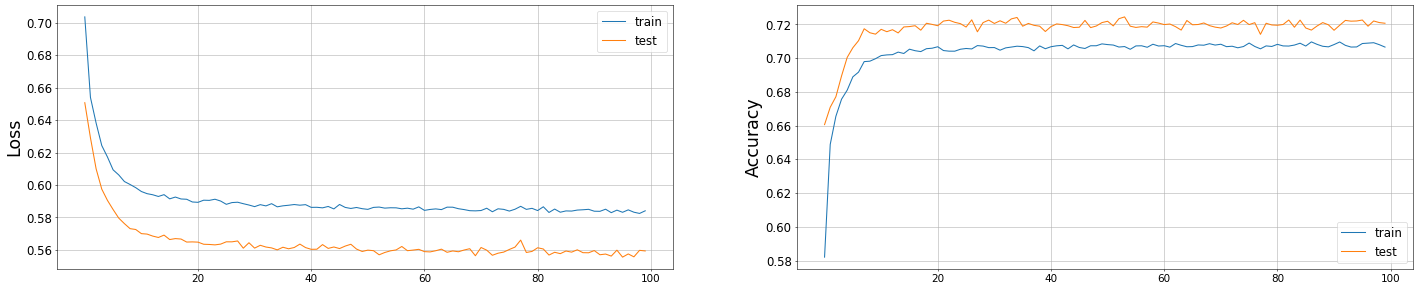

In [ ]:
"""
looking at the train/test loss and accuracy over the epochs
"""

width_in_inches = 35
height_in_inches = 7
dots_per_inch = 50

plt.figure(
    figsize=(width_in_inches, height_in_inches), dpi=dots_per_inch)

# PICK THE FOLD
fold = 5

# plot loss during training
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylabel('Loss', fontsize=25, color='black')
plt.xticks(range(20, len(history.history['loss'])+1, 20), fontsize=15, color='black')
plt.yticks(fontsize=17, color='black')
plt.legend(loc='upper right', fontsize=17)
plt.grid()
plt.savefig('/content/drive/My Drive/Official folder for Trashout/Task_1/models/pedro/final_model/train.png')

# plot accuracy during training
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.ylabel('Accuracy', fontsize=25, color='black')
plt.xticks(range(20, len(history.history['accuracy'])+1, 20), fontsize=15, color='black')
plt.yticks(fontsize=17, color='black')
plt.legend(fontsize=17)
plt.grid()
plt.savefig('/content/drive/My Drive/Official folder for Trashout/Task_1/models/pedro/final_model/test.png')

plt.show()

In [ ]:
"""
printing the confusion matrix
"""

preds = load_model(filepath_curr).predict(test_x).squeeze()
np.expand_dims(test_y, axis=1)

threshold = 0.5
preds[preds >= threshold] = 1
preds[preds < threshold] = 0

assert preds.shape == test_y.shape, 'The shapes of the two tensors are unequal'

print(confusion_matrix(test_y, preds))

print(classification_report(test_y, np.round(preds)))

[[5712 5328]
 [4675 6507]]
              precision    recall  f1-score   support

           0       0.55      0.52      0.53     11040
           1       0.55      0.58      0.57     11182

    accuracy                           0.55     22222
   macro avg       0.55      0.55      0.55     22222
weighted avg       0.55      0.55      0.55     22222



In [ ]:
preds = load_model(filepath_curr).predict(test_x).squeeze()
t = 0.0
print('in testy', len(test_y[test_y==0]), len(test_y[test_y==1]))
print('\n\n')
while t < 1.1:
  print(t, len(preds[preds < t]), len(preds[preds >= t]))
  t += 0.1

in testy 10937 11102



0.0 0 22039
0.1 10712 11327
0.2 10731 11308
0.30000000000000004 10741 11298
0.4 10755 11284
0.5 10760 11279
0.6 10768 11271
0.7 10776 11263
0.7999999999999999 10789 11250
0.8999999999999999 10808 11231
0.9999999999999999 11106 10933
1.0999999999999999 22039 0
